In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
train_data = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_data  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw




Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


SAMPLE AT INDEX 0
LABEL: 5


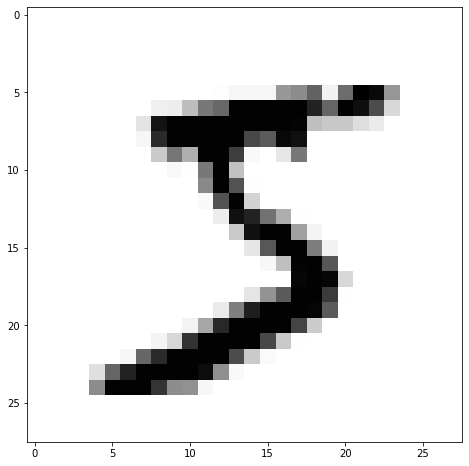

In [ ]:
sample_index = 0
image = train_data[sample_index][0]
label = train_data[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
class ImageDataset(Dataset):

  def __init__(self, dataset, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    # Get x and y values from each line and append to self.data

    self.data = []
    to_tensor = torchvision.transforms.ToTensor()
    for d in dataset:
      image = d[0]
      label = d[1]
      image = to_tensor(image)
      #image = torch.reshape(image, (-1,))
      label = torch.tensor(label).long()
      self.data.append((image, label))

    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, sample):
      image = sample[0]
      label = sample[1]
      return (image + torch.randn(image.size()) * self.std + self.mean, image, label)
    
    def __repr__(self):
      return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
#def random_search():
  

# Convolutional Autoencoder

In [ ]:
composed_transform = None

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

**Remember to mention in the report that with dropout images reconstruction is worser**

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, drop1=0.1, drop2=0.1, drop3=0.1, drop4=0.1):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            ##############################
            nn.Conv2d(1, 24, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            ##############################
            nn.Dropout(drop1),

            # Second convolutional layer
            ##############################
            nn.Conv2d(24, 48, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            ##############################
            nn.Dropout(drop2),

            # Third convolutional layer
            ##############################
            nn.Conv2d(48, 96, kernel_size=(3, 3), stride=2, padding=0),
            #nn.ReLU()
            ##############################
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        nn.Dropout(drop3),

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            ##############################
            nn.Linear(96 * 3 * 3, 128),
            nn.ReLU(),
            ##############################
            nn.Dropout(drop4),
            # Second linear layer
            ##############################
            nn.Linear(128, encoded_space_dim),
            nn.ReLU(),
            ##############################
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)

        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, drop1=0.1, drop2=0.1, drop3=0.1, drop4=0.1):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            ##############################
            #nn.Dropout(drop1),

            # Second linear layer
            ##############################
            nn.Linear(128, 3 * 3 * 96),
            nn.ReLU(True),
  
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(96, 3, 3))
        #nn.Dropout(drop3),

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First convolutional layer
            ##############################
            nn.ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=2, output_padding=0),
            nn.ReLU(),
            ##############################
            #nn.Dropout(drop2),

            # Second convolutional layer
            ##############################
            nn.ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ##############################
            #nn.Dropout(drop4),

            # Third convolutional layer
            ##############################
            nn.ConvTranspose2d(24, 1, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            #nn.ReLU()
            ##############################
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.decoder_lin(x)

        # Unflatten
        x = self.unflatten(x)
        
        # Apply linear layers
        x = self.decoder_conv(x)

        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-4)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=864, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(96, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(24, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noised = False, verbose = True):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        if noised:
          image = image_batch[0].to(device)
        else:
          image = image_batch[0].to(device)

        # Encode data
        encoded = encoder(image)

        # Decode data
        decoded = decoder(encoded)

        # Evaluate loss
        if noised:
          original = image_batch[1].to(device)
          loss = loss_fn(decoded, original)
        else:
          loss = loss_fn(decoded, image)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch loss
        if verbose:
          print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noised = False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            if noised:
              image = image_batch[0].to(device)
            else:
              image = image_batch[0].to(device)

            # Encode data
            encoded = encoder(image)

            # Decode data
            decoded_data = decoder(encoded)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            if noised:
              conc_label.append(image_batch[1].cpu())
            else:
              conc_label.append(image_batch[0].cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def cross_validation(encoder, decoder, device, loss_fn, optimizer, full_dataset, batch_size, cv=5, verbose=True):

  from sklearn.model_selection import KFold

  kf = KFold(n_splits=cv)
  train_errors = []
  val_errors = []
  count_fold = 0
  for train_indexes, val_indexes in kf.split(full_dataset):
    train_dataset = torch.utils.data.Subset(full_dataset, train_indexes) #Train dataset
    validation_dataset = torch.utils.data.Subset(full_dataset, val_indexes) #Validation Dataset

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)

    train_loss = train_epoch(encoder, decoder, device, train_dataloader, loss_fn, optimizer, verbose=False)

    val_loss = test_epoch(encoder, decoder, device, val_dataloader, loss_fn)

    if verbose:
      print("[Fold %d] Train error: %f - Validation Error: %f" % (count_fold, train_loss, val_loss))

    train_errors.append(train_loss)
    val_errors.append(val_loss)
    count_fold += 1

  return np.mean(train_errors), np.mean(val_errors)

In [ ]:
def grid_search(encoded_space_dim, loss_fn, device, batch_size, cv, dataset, hyperparameters, verbose = True):
  totIter = 1
  for key, value in hyperparameters.items():
    totIter *= len(value)
  print("\n\nTOTAL ITERATIONS: %d\n\n" %(totIter))
  best_loss = None
  best_params = {'lr': None, 'weight_decay': None, 'epochs': None}
  for epochs in hyperparameters['epochs']:
    for lr in hyperparameters['lr']:
      for weight_decay in hyperparameters['weight_decay']:

        encoder = Encoder(encoded_space_dim)
        decoder = Decoder(encoded_space_dim)

        params_to_optimize = [
          {'params': encoder.parameters()},
          {'params': decoder.parameters()}
        ]
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

        encoder.to(device)
        decoder.to(device)
        train_loss = []
        val_loss = []
        print("\n\nTRAINING NEW MODEL\n\n")

        for ep in range(epochs):
          if verbose:
            print("Epoch %d/%d\n\n" % (ep, epochs))
          train_loss_epoch, val_loss_epoch = cross_validation(encoder, decoder, device, loss_fn, optim, dataset, batch_size, cv, verbose)
          train_loss.append(train_loss_epoch)
          val_loss.append(val_loss_epoch)
          if verbose:
            print("Train loss: %f - Validation loss: %f" % (train_loss_epoch, val_loss_epoch))
        train_loss = np.mean(train_loss_epoch)
        val_loss = np.mean(val_loss_epoch)

        # Print Validationloss
        print('\n\n\t VALIDATION loss: %f\n\n' % (val_loss))

        if best_loss is None or val_loss < best_loss:
          best_loss = val_loss
          best_params['epochs'] = ep
          best_params['lr'] = lr
          best_params['weight_decay'] = weight_decay

        print('\n\n\t BEST VALIDATION loss: %f\n\n' % (best_loss))
        print("BEST PARAMS")
        print(best_params)
        print("\n\n")

  print("\n\nMODEL SELECTION FINISHED\n\n")
  print("BEST PARAMS")
  print(best_params)

In [ ]:
loss_fn = torch.nn.MSELoss()
hyperparameters = {'lr': [0.001, 0.02], 'weight_decay': [0.0001, 0.005], 'epochs': [1]}
grid_search(encoded_space_dim, loss_fn, device, 100, 3, full_dataset, hyperparameters)



TOTAL ITERATIONS: 4




TRAINING NEW MODEL


Epoch 0/1


[Fold 0] Train error: 0.080686 - Validation Error: 0.056618
[Fold 1] Train error: 0.053998 - Validation Error: 0.052417
[Fold 2] Train error: 0.051942 - Validation Error: 0.050395
Train loss: 0.062209 - Validation loss: 0.053143


	 VALIDATION loss: 0.053143




	 BEST VALIDATION loss: 0.053143


BEST PARAMS
{'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 0}





TRAINING NEW MODEL


Epoch 0/1


[Fold 0] Train error: 0.095654 - Validation Error: 0.081149
[Fold 1] Train error: 0.082740 - Validation Error: 0.084780
[Fold 2] Train error: 0.082536 - Validation Error: 0.081150
Train loss: 0.086977 - Validation loss: 0.082360


	 VALIDATION loss: 0.082360




	 BEST VALIDATION loss: 0.053143


BEST PARAMS
{'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 0}





TRAINING NEW MODEL


Epoch 0/1


[Fold 0] Train error: 0.068367 - Validation Error: 0.062526
[Fold 1] Train error: 0.058489 - Validation Error: 0.065233
[Fold 2] Train error: 0

In [ ]:
should_train = True

EPOCH 1/20
[Fold 0] Train error: 0.079160 - Validation Error: 0.056821
[Fold 1] Train error: 0.053773 - Validation Error: 0.051515
[Fold 2] Train error: 0.050563 - Validation Error: 0.048747


	 VALIDATION - EPOCH 1/20 - loss: 0.052361


torch.Size([1, 1, 28, 28])


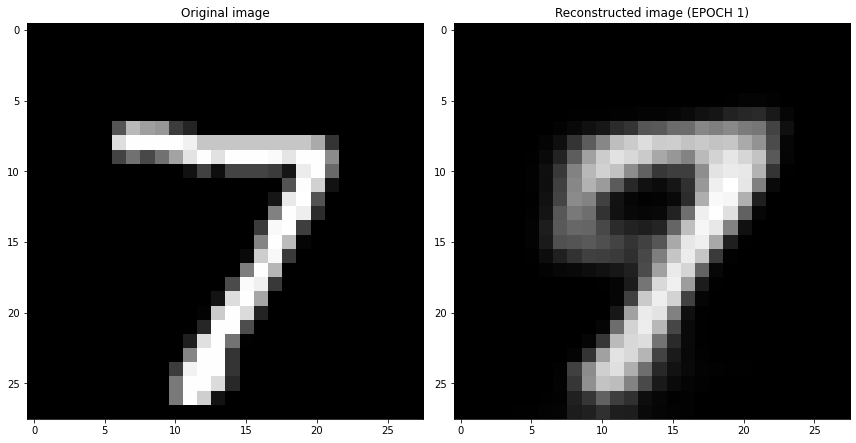

EPOCH 2/20
[Fold 0] Train error: 0.048955 - Validation Error: 0.048207
[Fold 1] Train error: 0.048112 - Validation Error: 0.047941
[Fold 2] Train error: 0.047836 - Validation Error: 0.047230


	 VALIDATION - EPOCH 2/20 - loss: 0.047792


torch.Size([1, 1, 28, 28])


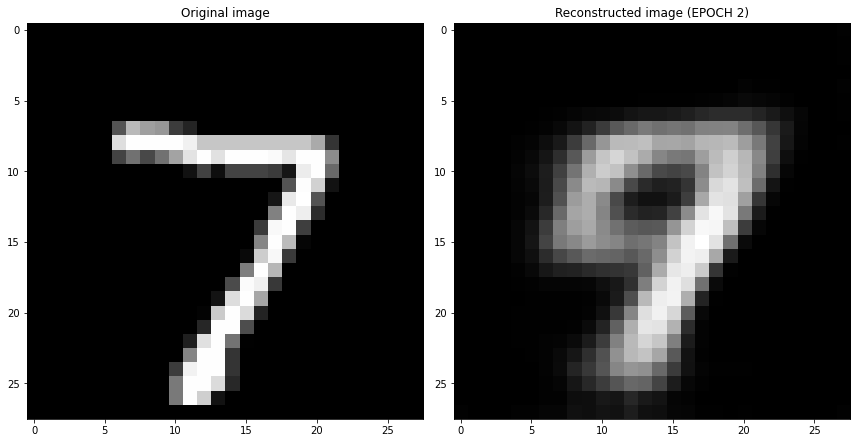

EPOCH 3/20
[Fold 0] Train error: 0.047341 - Validation Error: 0.046790
[Fold 1] Train error: 0.046845 - Validation Error: 0.046718
[Fold 2] Train error: 0.046814 - Validation Error: 0.046115


	 VALIDATION - EPOCH 3/20 - loss: 0.046541


torch.Size([1, 1, 28, 28])


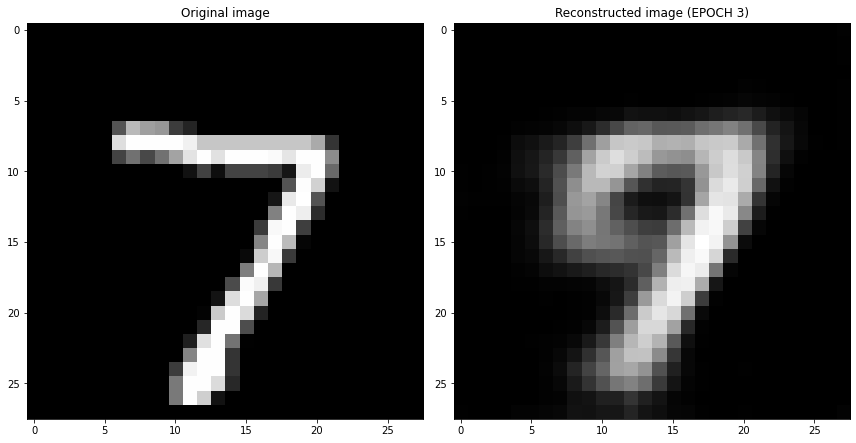

EPOCH 4/20
[Fold 0] Train error: 0.046428 - Validation Error: 0.045906
[Fold 1] Train error: 0.046064 - Validation Error: 0.046004
[Fold 2] Train error: 0.046208 - Validation Error: 0.045137


	 VALIDATION - EPOCH 4/20 - loss: 0.045683


torch.Size([1, 1, 28, 28])


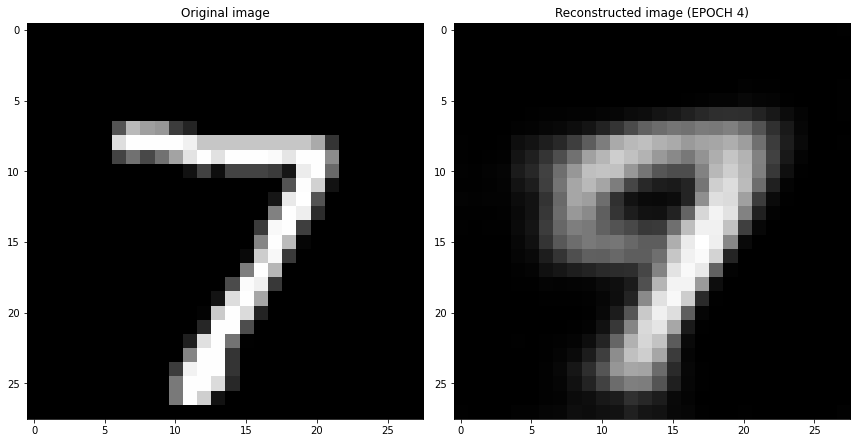

EPOCH 5/20
[Fold 0] Train error: 0.045845 - Validation Error: 0.045360
[Fold 1] Train error: 0.045588 - Validation Error: 0.045340
[Fold 2] Train error: 0.045753 - Validation Error: 0.044766


	 VALIDATION - EPOCH 5/20 - loss: 0.045155


torch.Size([1, 1, 28, 28])


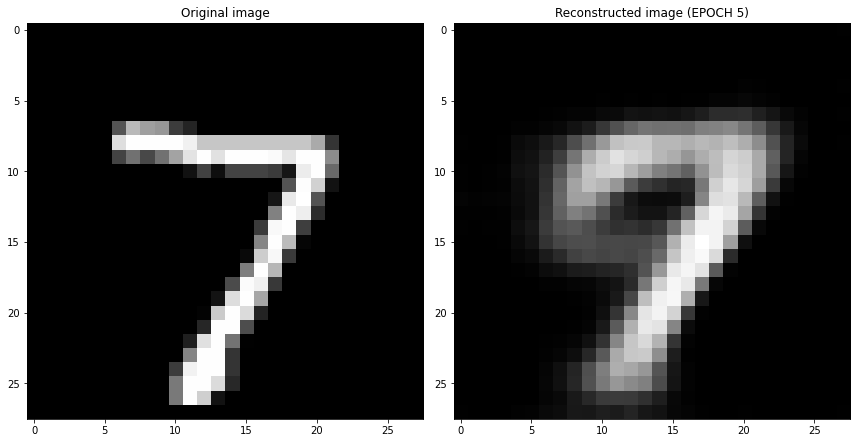

EPOCH 6/20
[Fold 0] Train error: 0.045452 - Validation Error: 0.044912
[Fold 1] Train error: 0.045205 - Validation Error: 0.045561
[Fold 2] Train error: 0.045450 - Validation Error: 0.044494


	 VALIDATION - EPOCH 6/20 - loss: 0.044989


torch.Size([1, 1, 28, 28])


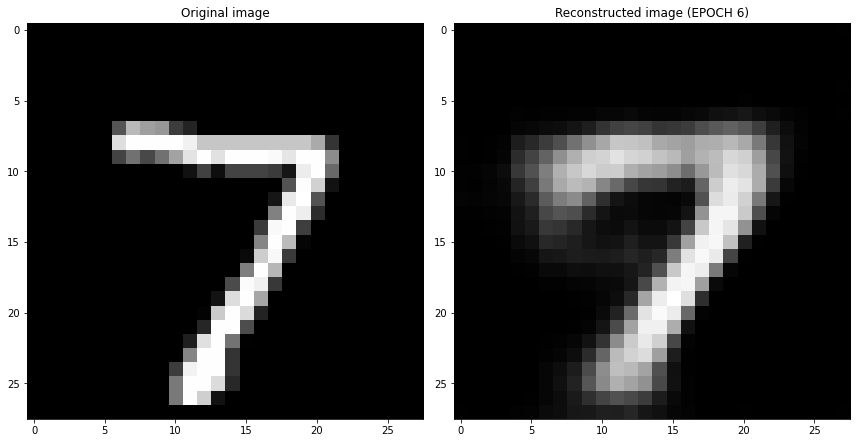

EPOCH 7/20
[Fold 0] Train error: 0.045148 - Validation Error: 0.044912
[Fold 1] Train error: 0.044954 - Validation Error: 0.045234
[Fold 2] Train error: 0.045155 - Validation Error: 0.044494


	 VALIDATION - EPOCH 7/20 - loss: 0.044880


torch.Size([1, 1, 28, 28])


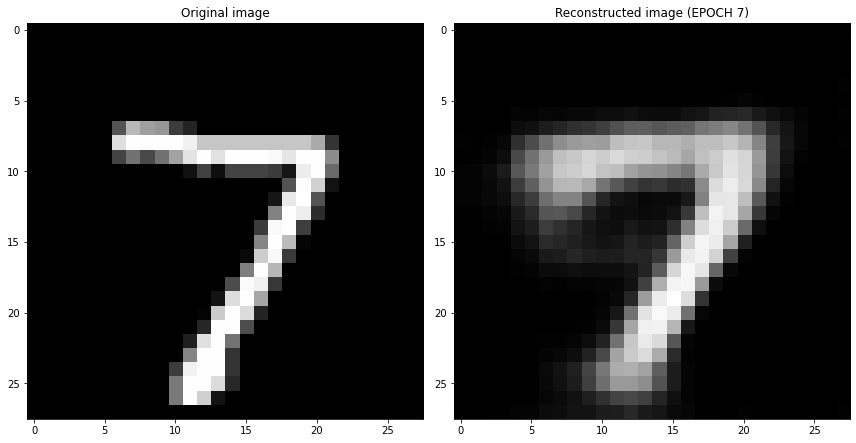

EPOCH 8/20
[Fold 0] Train error: 0.044868 - Validation Error: 0.044322
[Fold 1] Train error: 0.044667 - Validation Error: 0.044494
[Fold 2] Train error: 0.044925 - Validation Error: 0.044047


	 VALIDATION - EPOCH 8/20 - loss: 0.044288


torch.Size([1, 1, 28, 28])


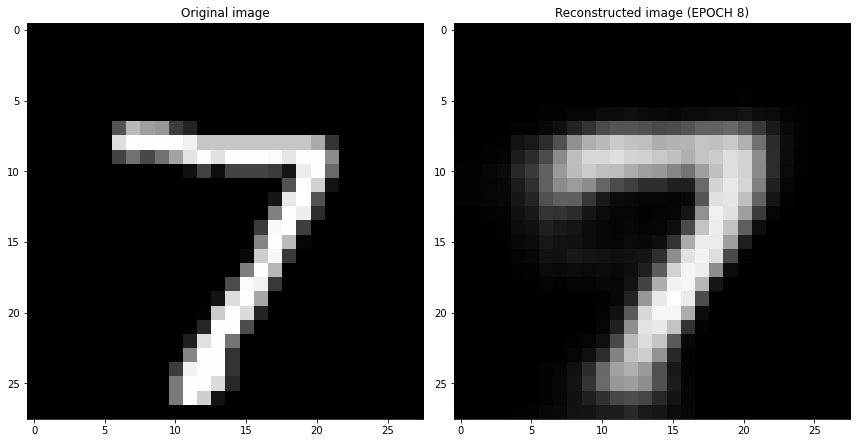

EPOCH 9/20
[Fold 0] Train error: 0.044597 - Validation Error: 0.044091
[Fold 1] Train error: 0.044431 - Validation Error: 0.044331
[Fold 2] Train error: 0.044675 - Validation Error: 0.043648


	 VALIDATION - EPOCH 9/20 - loss: 0.044023


torch.Size([1, 1, 28, 28])


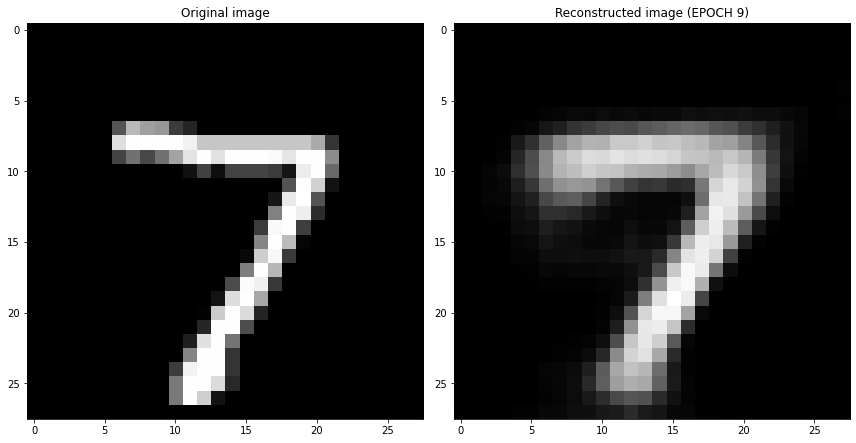

EPOCH 10/20
[Fold 0] Train error: 0.044323 - Validation Error: 0.043897
[Fold 1] Train error: 0.044206 - Validation Error: 0.044015
[Fold 2] Train error: 0.044421 - Validation Error: 0.043738


	 VALIDATION - EPOCH 10/20 - loss: 0.043883


torch.Size([1, 1, 28, 28])


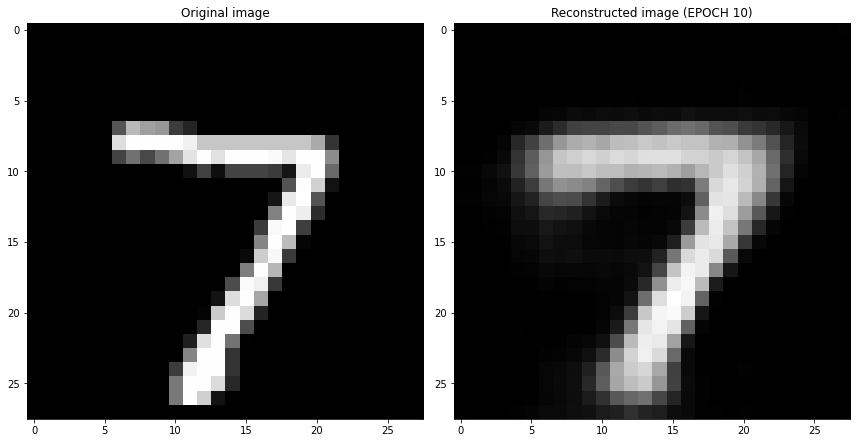

EPOCH 11/20
[Fold 0] Train error: 0.044210 - Validation Error: 0.043859
[Fold 1] Train error: 0.044038 - Validation Error: 0.043734
[Fold 2] Train error: 0.044299 - Validation Error: 0.043125


	 VALIDATION - EPOCH 11/20 - loss: 0.043573


torch.Size([1, 1, 28, 28])


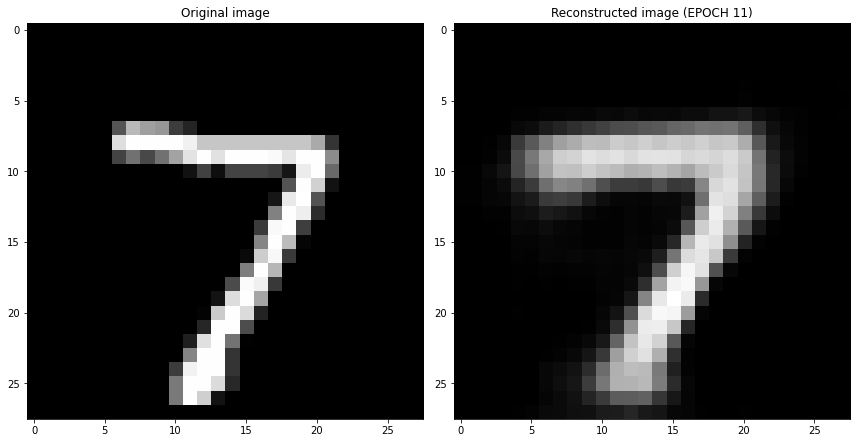

EPOCH 12/20
[Fold 0] Train error: 0.044039 - Validation Error: 0.043550
[Fold 1] Train error: 0.043887 - Validation Error: 0.043748
[Fold 2] Train error: 0.044181 - Validation Error: 0.043324


	 VALIDATION - EPOCH 12/20 - loss: 0.043540


torch.Size([1, 1, 28, 28])


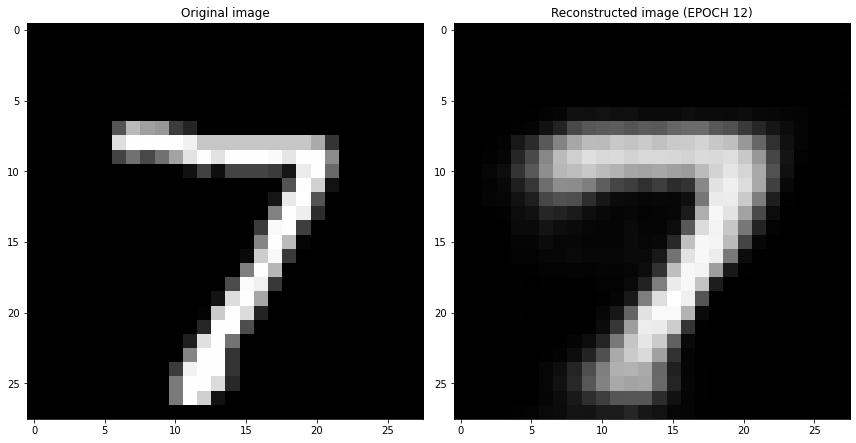

EPOCH 13/20
[Fold 0] Train error: 0.043827 - Validation Error: 0.043440
[Fold 1] Train error: 0.043795 - Validation Error: 0.043569
[Fold 2] Train error: 0.044058 - Validation Error: 0.043088


	 VALIDATION - EPOCH 13/20 - loss: 0.043366


torch.Size([1, 1, 28, 28])


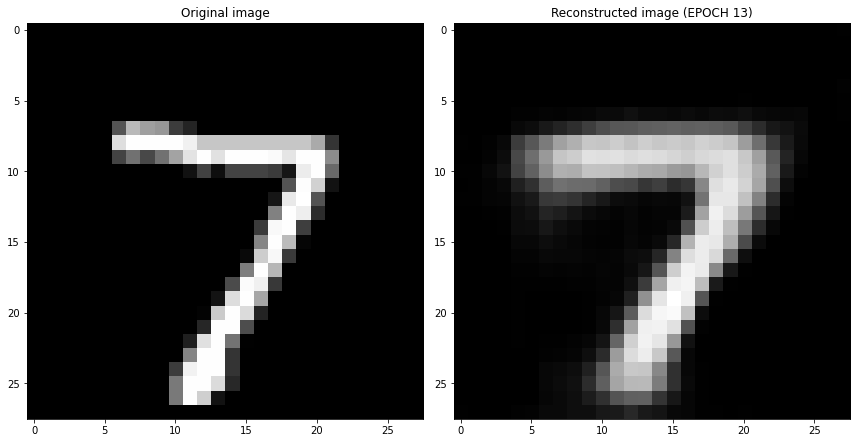

EPOCH 14/20
[Fold 0] Train error: 0.043778 - Validation Error: 0.043483
[Fold 1] Train error: 0.043767 - Validation Error: 0.043694
[Fold 2] Train error: 0.043962 - Validation Error: 0.042700


	 VALIDATION - EPOCH 14/20 - loss: 0.043293


torch.Size([1, 1, 28, 28])


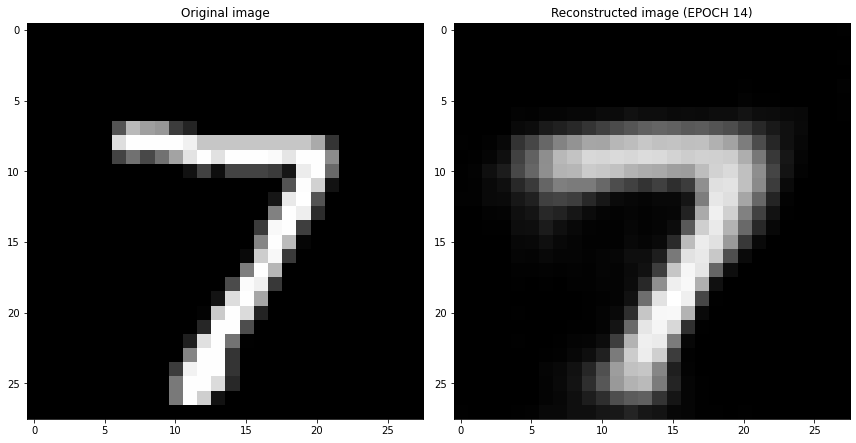

EPOCH 15/20
[Fold 0] Train error: 0.043703 - Validation Error: 0.043227
[Fold 1] Train error: 0.043632 - Validation Error: 0.043534
[Fold 2] Train error: 0.043895 - Validation Error: 0.042850


	 VALIDATION - EPOCH 15/20 - loss: 0.043204


torch.Size([1, 1, 28, 28])


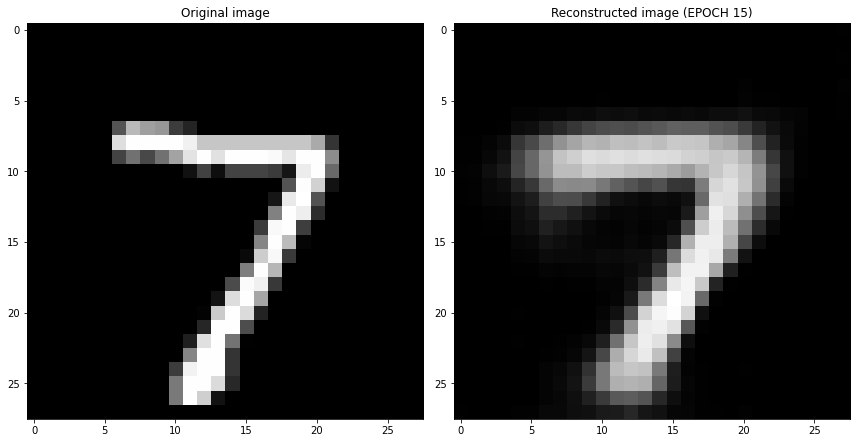

EPOCH 16/20
[Fold 0] Train error: 0.043640 - Validation Error: 0.043157
[Fold 1] Train error: 0.043544 - Validation Error: 0.043423
[Fold 2] Train error: 0.043793 - Validation Error: 0.042921


	 VALIDATION - EPOCH 16/20 - loss: 0.043167


torch.Size([1, 1, 28, 28])


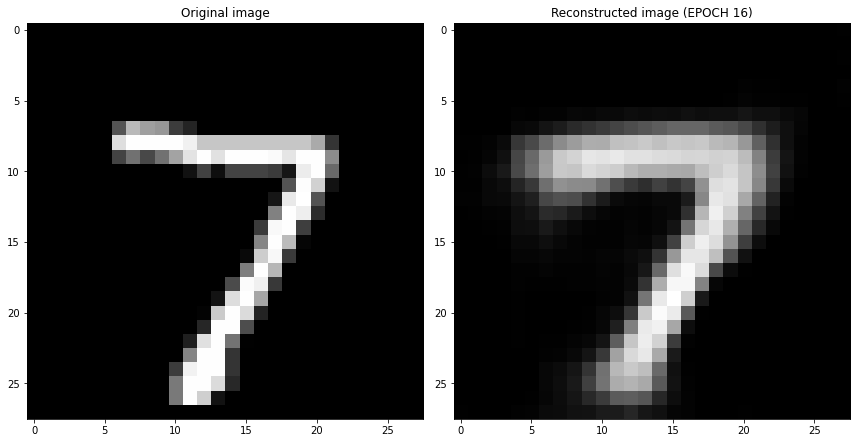

EPOCH 17/20
[Fold 0] Train error: 0.043583 - Validation Error: 0.043100
[Fold 1] Train error: 0.043509 - Validation Error: 0.043199
[Fold 2] Train error: 0.043814 - Validation Error: 0.042894


	 VALIDATION - EPOCH 17/20 - loss: 0.043064


torch.Size([1, 1, 28, 28])


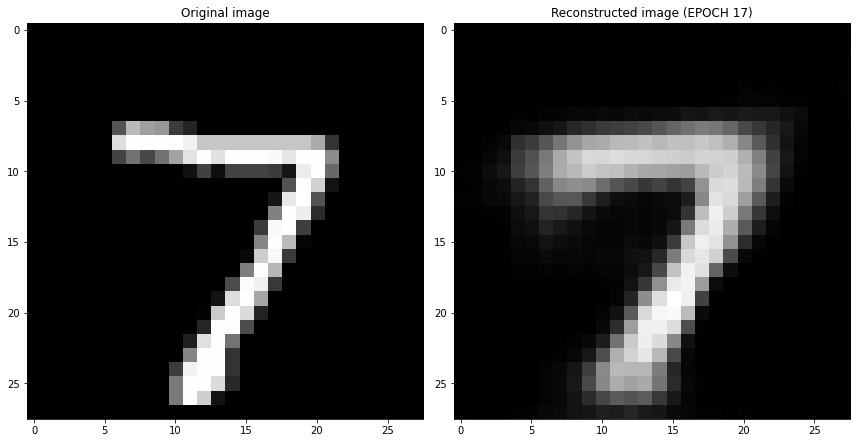

EPOCH 18/20
[Fold 0] Train error: 0.043579 - Validation Error: 0.043155
[Fold 1] Train error: 0.043446 - Validation Error: 0.043160
[Fold 2] Train error: 0.043761 - Validation Error: 0.042580


	 VALIDATION - EPOCH 18/20 - loss: 0.042965


torch.Size([1, 1, 28, 28])


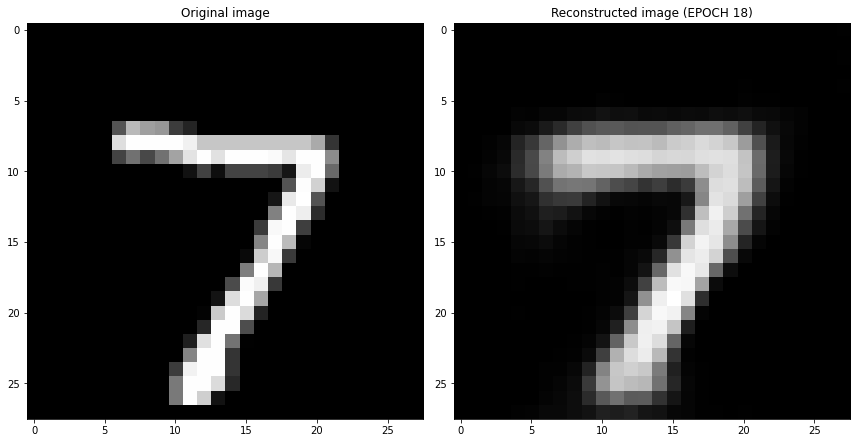

EPOCH 19/20
[Fold 0] Train error: 0.043466 - Validation Error: 0.043227
[Fold 1] Train error: 0.043456 - Validation Error: 0.043366
[Fold 2] Train error: 0.043725 - Validation Error: 0.042673


	 VALIDATION - EPOCH 19/20 - loss: 0.043089


torch.Size([1, 1, 28, 28])


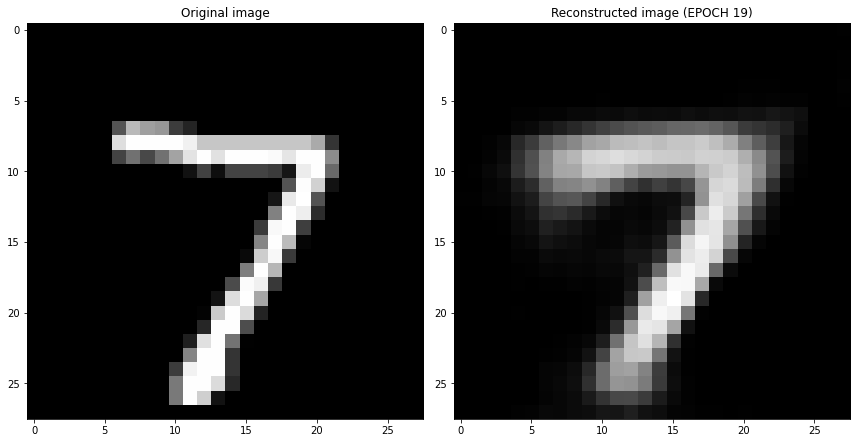

EPOCH 20/20
[Fold 0] Train error: 0.043517 - Validation Error: 0.043292
[Fold 1] Train error: 0.043415 - Validation Error: 0.042967
[Fold 2] Train error: 0.043702 - Validation Error: 0.042865


	 VALIDATION - EPOCH 20/20 - loss: 0.043042


torch.Size([1, 1, 28, 28])


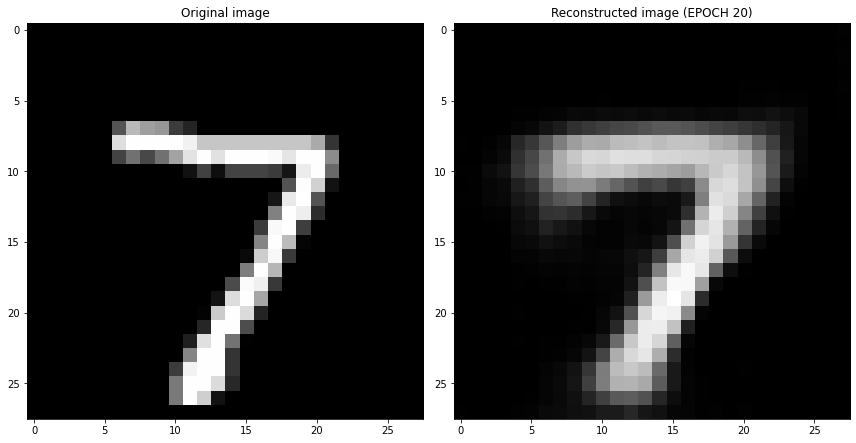

In [ ]:
if should_train:
  ### Training cycle
  num_epochs = 20
  train_loss_log = []
  val_loss_log = []
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      ### Training (use the training function)
      train_loss, val_loss = cross_validation(encoder, decoder, device, loss_fn, optim, full_dataset, 128, 3)
      # Print Validationloss
      print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

      train_loss_log.append(train_loss)
      val_loss_log.append(val_loss)
      ### Plot progress
      # Get the output of a specific image (the test image at index 0 in this case)
      img = test_dataset[0][0].unsqueeze(0).to(device)
      print(img.shape)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          encoded = encoder(img)
          rec_img = decoder(encoded)
      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()

      # Save network parameters
      torch.save(encoder.state_dict(), 'encoder_params.pth')
      torch.save(decoder.state_dict(), 'decoder_params.pth')

      # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
else: #Load the model
  encoder.load_state_dict(torch.load('encoder_params.pth'))
  decoder.load_state_dict(torch.load('decoder_params.pth'))


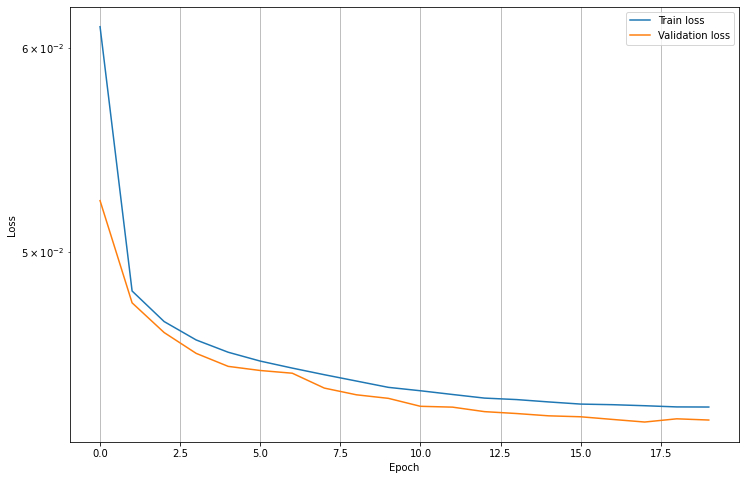

In [ ]:
if should_train:
  plt.figure(figsize=(12,8))
  plt.semilogy(train_loss_log, label='Train loss')
  plt.semilogy(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

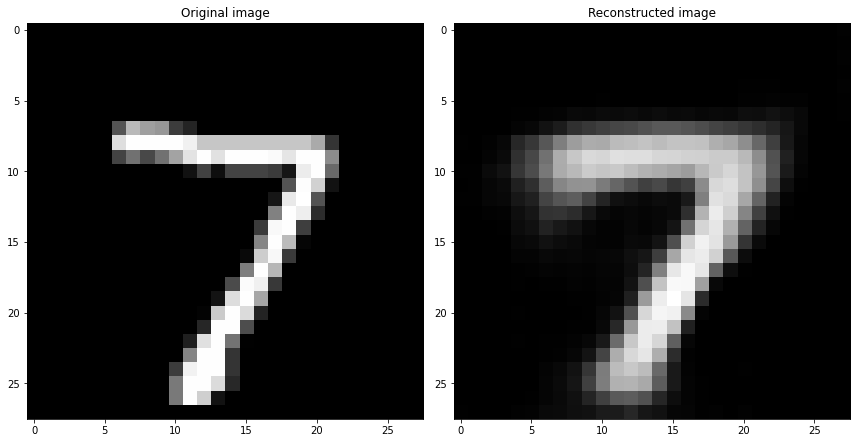

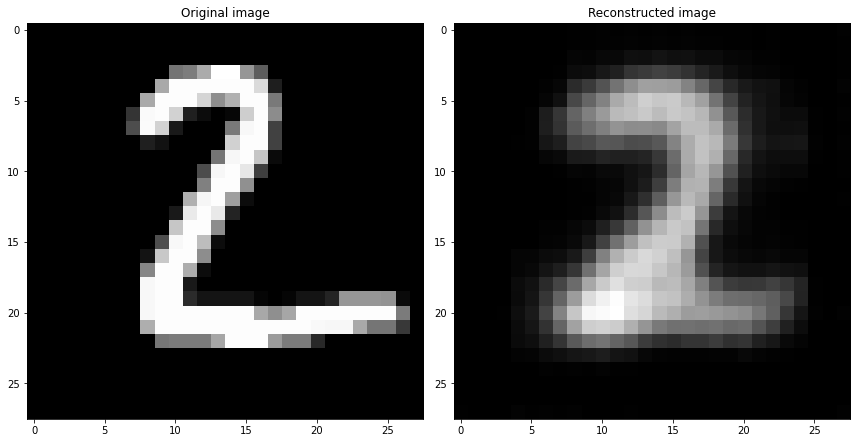

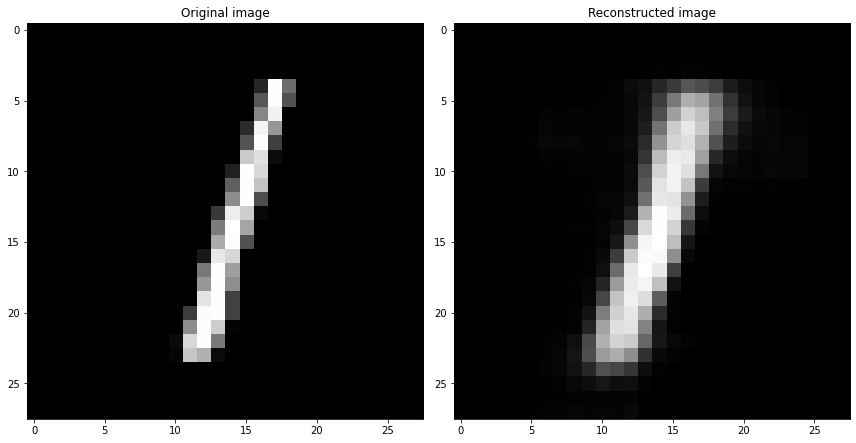

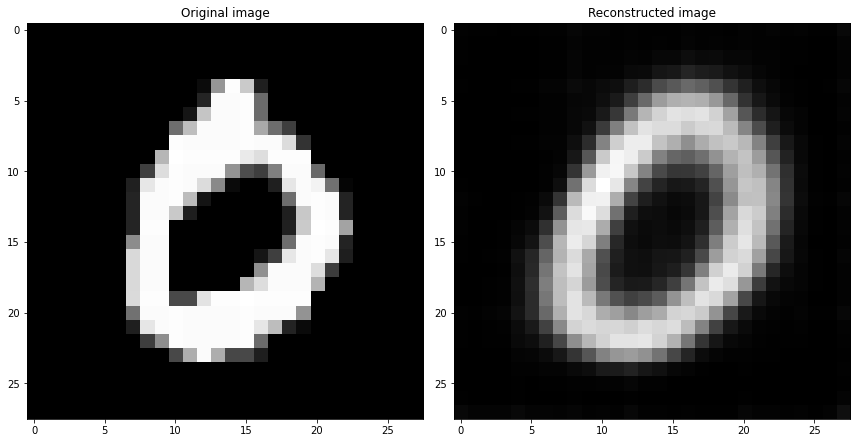

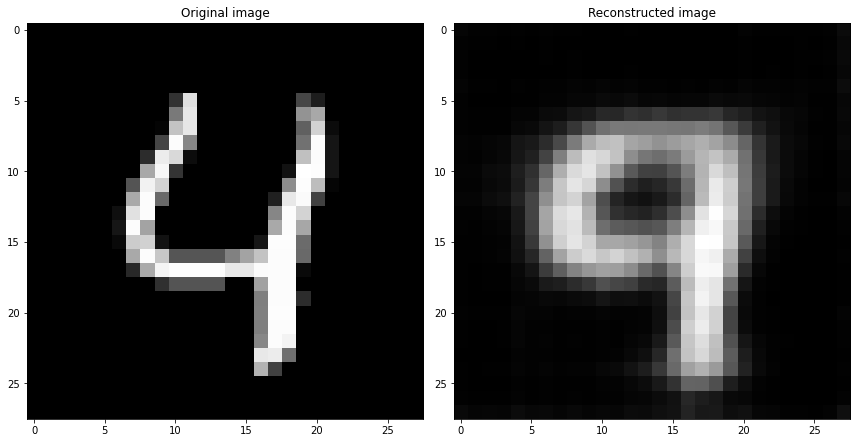

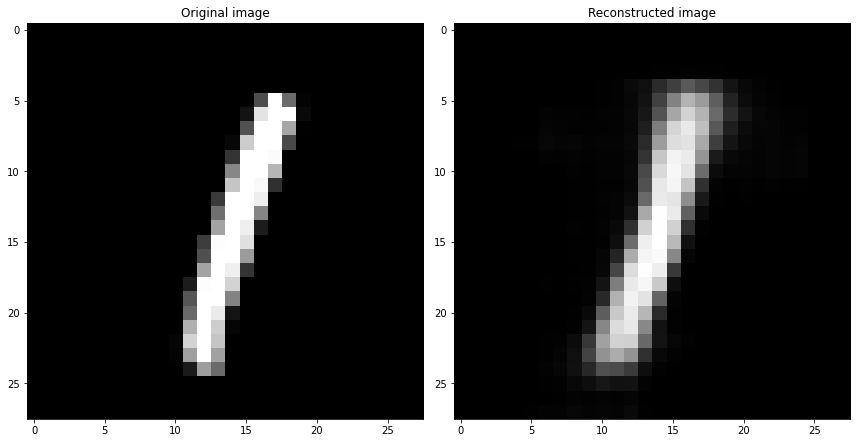

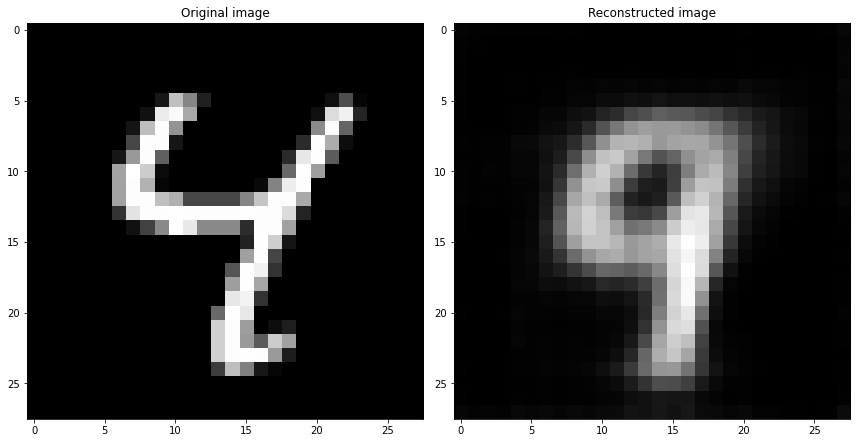

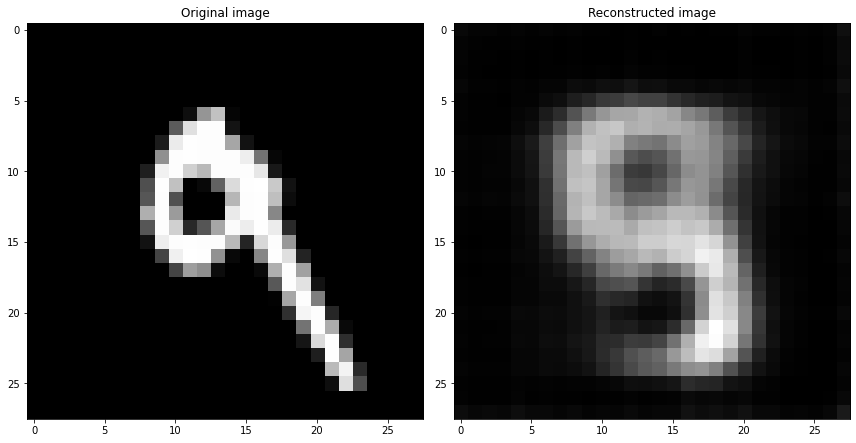

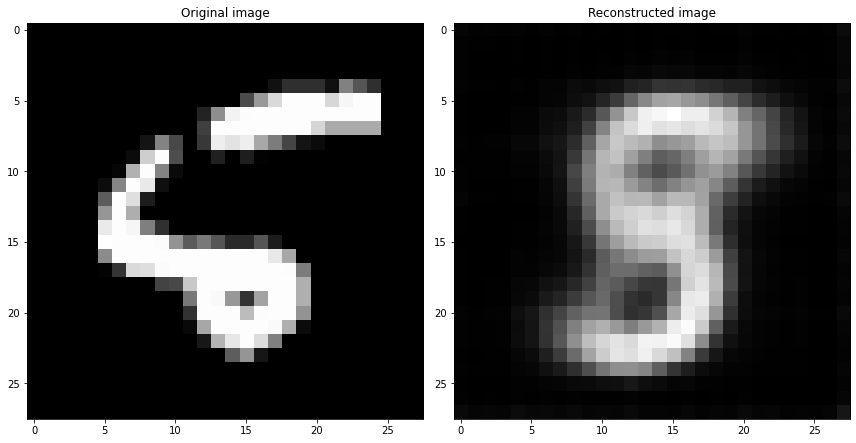

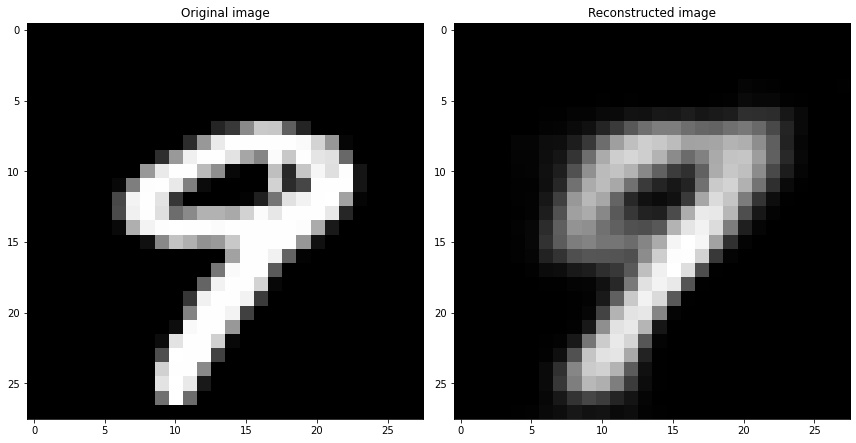

In [ ]:
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(10):
      original = image_batch[0].to(device)
      encoded = encoder(original)
      reconstructed = decoder(encoded)
      reconstructed = reconstructed[i][0]
      original = original[i]

      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(reconstructed.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      plt.tight_layout()
      plt.pause(0.1)
    break

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
labels = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append(encoded_img)
    labels.append(label)

100%|██████████| 10000/10000 [00:06<00:00, 1512.14it/s]


In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(2, init='pca', random_state=0).fit_transform(encoded_samples)

In [ ]:
import plotly.express as px
px.scatter(encoded_samples, x=tsne[:, 0], y=tsne[:, 1], color=labels, opacity=0.7)

tensor([[ 43., -78.]], device='cuda:0')


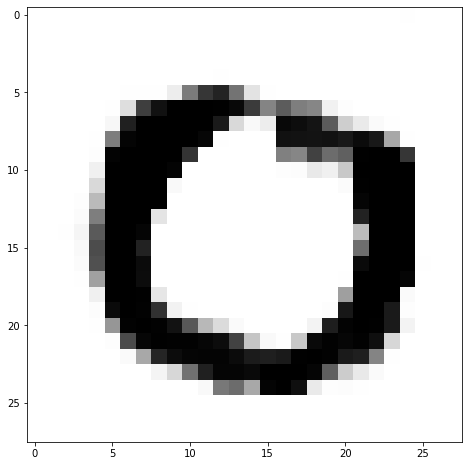

In [ ]:
torch.manual_seed(0)
random_latent_space = torch.randn(1, encoded_space_dim).to(device) * 30
random_latent_space[0][0] = 43
random_latent_space[0][1] = -78
#random_latent_space = random_latent_space.unsqueeze(0)
print(random_latent_space)
image_from_latent_space = decoder(random_latent_space).detach().cpu().numpy()

fig = plt.figure(figsize=(8,8))
plt.imshow(image_from_latent_space[0][0], cmap='Greys')

# Denoising Autoencoder

In [ ]:
composed_transform = transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
denoise_encoder = Encoder(encoded_space_dim=encoded_space_dim)
denoise_decoder = Decoder(encoded_space_dim=encoded_space_dim)
denoise_encoder = denoise_encoder.to(device)
denoise_decoder = denoise_decoder.to(device)

In [ ]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': denoise_encoder.parameters()},
    {'params': denoise_decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

EPOCH 1/5


	 VALIDATION - EPOCH 1/5 - loss: 0.067068


torch.Size([1, 1, 28, 28])


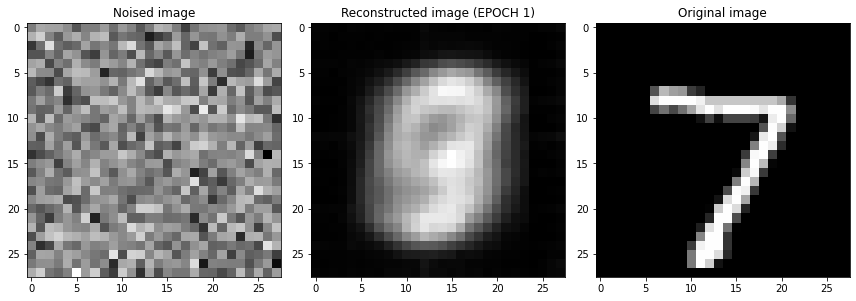

EPOCH 2/5


	 VALIDATION - EPOCH 2/5 - loss: 0.066977


torch.Size([1, 1, 28, 28])


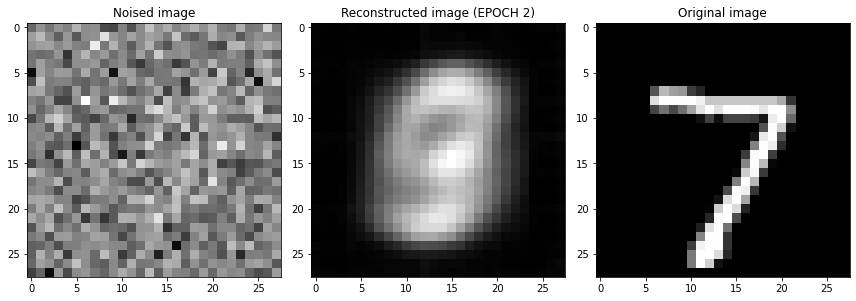

EPOCH 3/5


	 VALIDATION - EPOCH 3/5 - loss: 0.066976


torch.Size([1, 1, 28, 28])


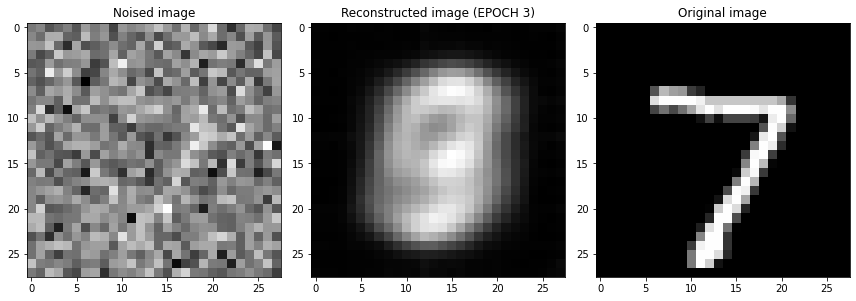

EPOCH 4/5


	 VALIDATION - EPOCH 4/5 - loss: 0.066953


torch.Size([1, 1, 28, 28])


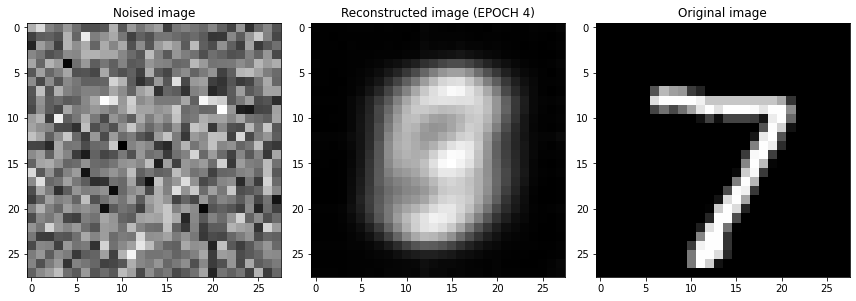

EPOCH 5/5


	 VALIDATION - EPOCH 5/5 - loss: 0.066991


torch.Size([1, 1, 28, 28])


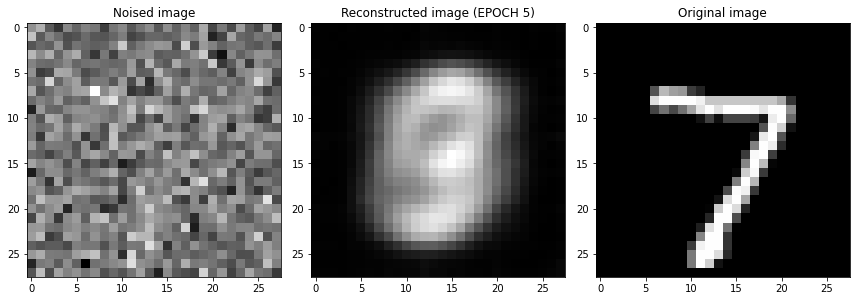

In [ ]:
### Training cycle
if should_train:
  num_epochs = 5
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      ### Training (use the training function)
      train_epoch(
          encoder=denoise_encoder, 
          decoder=denoise_decoder, 
          device=device, 
          dataloader=train_dataloader, 
          loss_fn=loss_fn, 
          optimizer=optim,
          noised=True,
          verbose=False)
      ### Validation  (use the testing function)
      val_loss = test_epoch(
          encoder=denoise_encoder, 
          decoder=denoise_decoder, 
          device=device, 
          dataloader=val_dataloader, 
          loss_fn=loss_fn,
          noised=True)
      # Print Validationloss
      print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

      ### Plot progress
      # Get the output of a specific image (the test image at index 0 in this case)
      #print(test_dataset[0][0])
      img = test_dataset[0][0].unsqueeze(0).to(device)
      original = test_dataset[0][1].unsqueeze(0).to(device)
      print(img.shape)
      denoise_encoder.eval()
      denoise_decoder.eval()
      with torch.no_grad():
          encoded = denoise_encoder(img)
          rec_img  = denoise_decoder(encoded)
      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 3, figsize=(12,6))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Noised image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
      axs[2].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[2].set_title('Original image')
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()

      # Save network parameters
      torch.save(denoise_encoder.state_dict(), 'encoder_denoising_params.pth')
      torch.save(denoise_decoder.state_dict(), 'decoder_denoising_params.pth')

      # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
else:
  denoise_encoder.load_state_dict(torch.load('encoder_denoising_params.pth'))
  denoise_decoder.load_state_dict(torch.load('decoder_denoising_params.pth'))

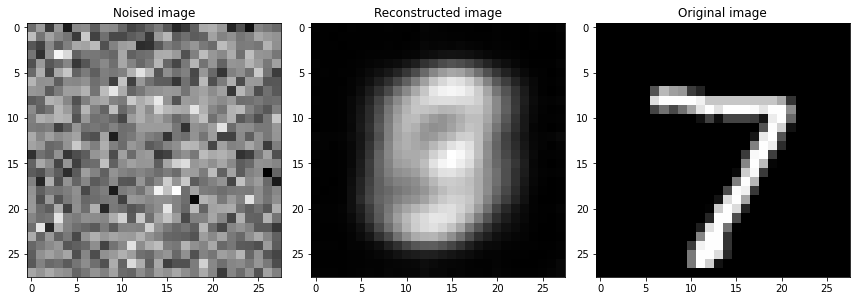

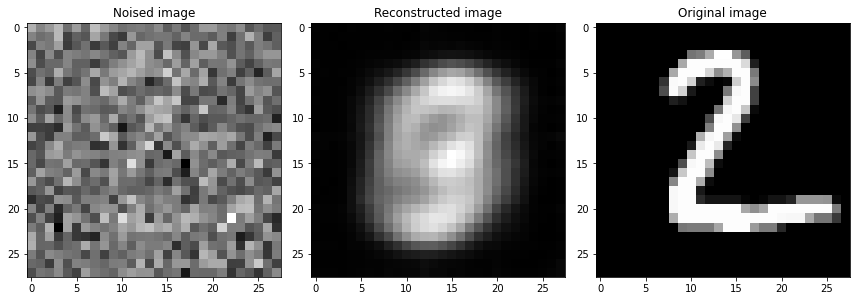

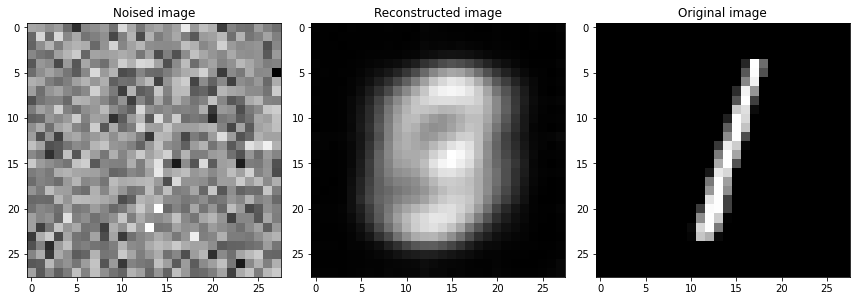

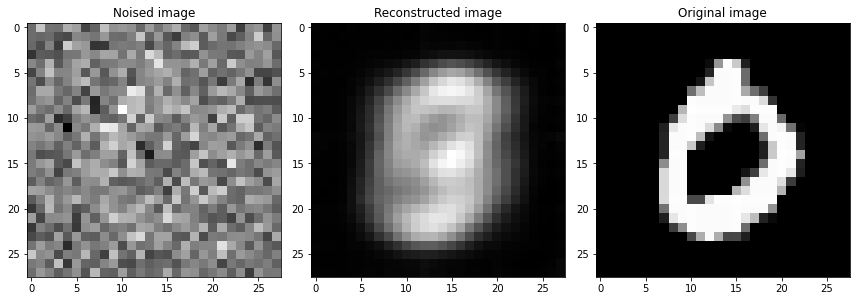

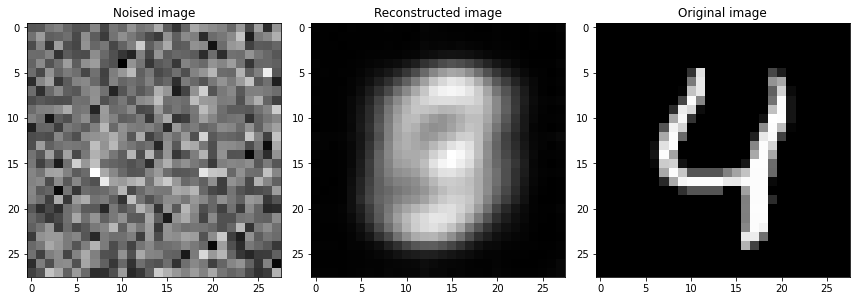

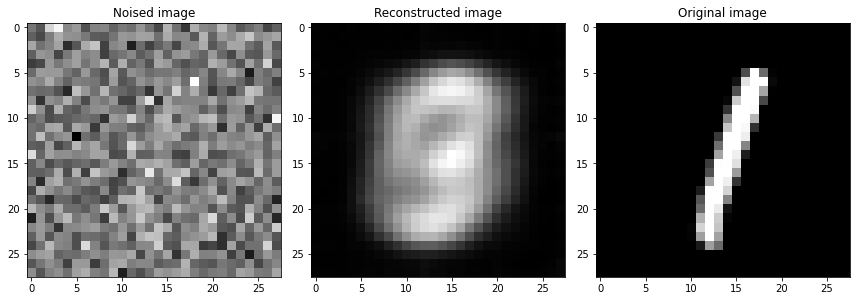

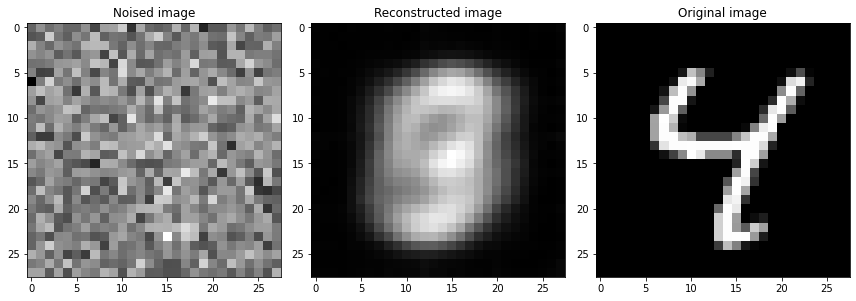

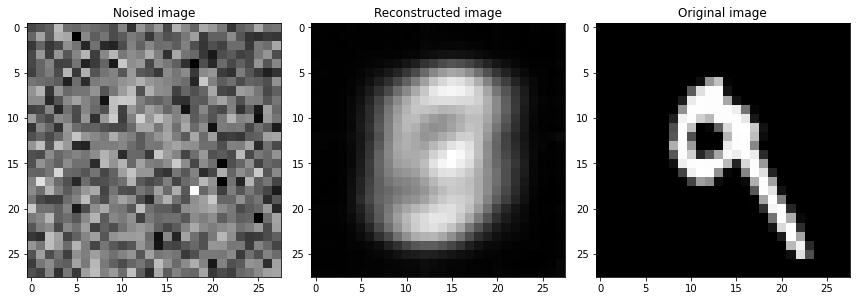

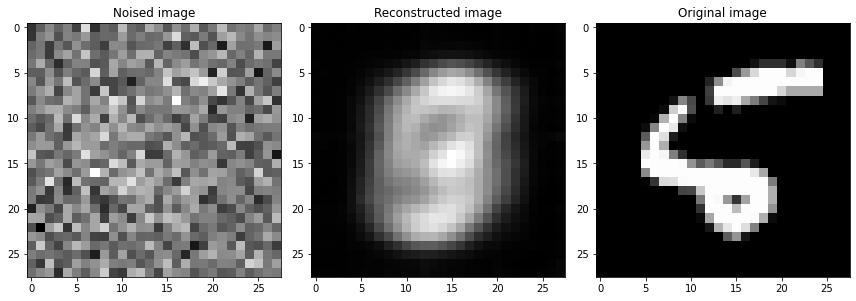

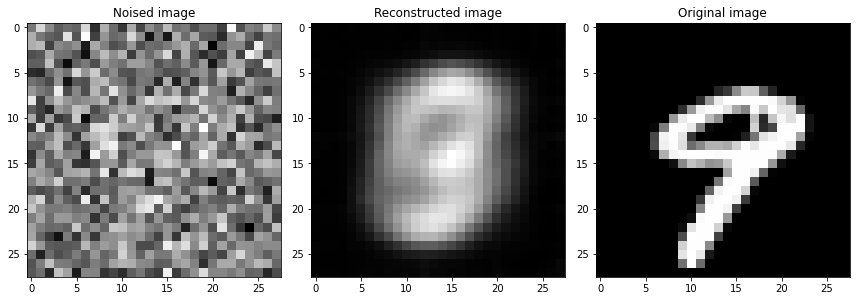

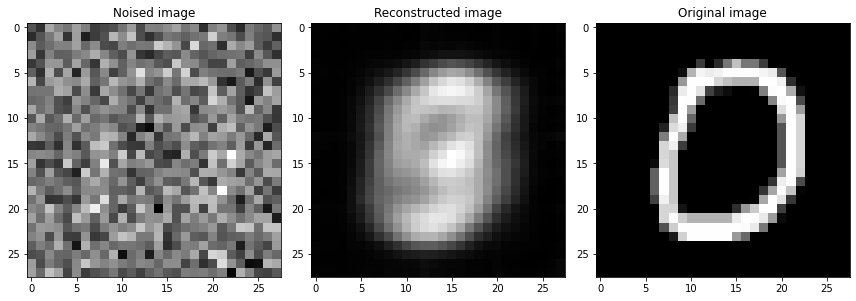

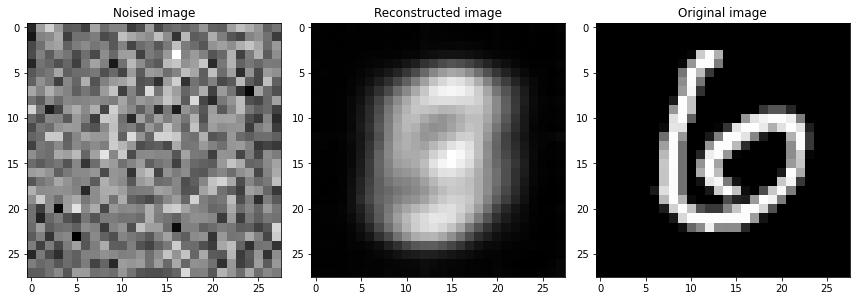

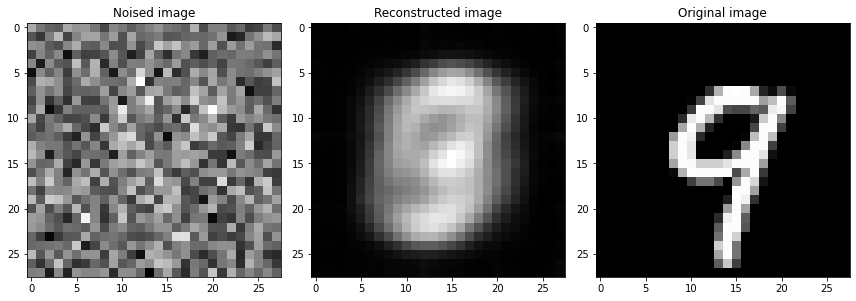

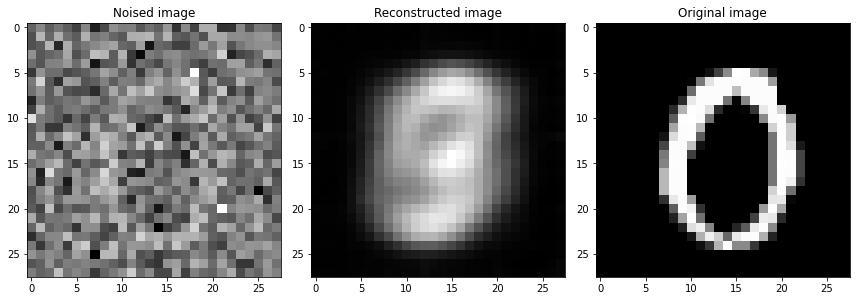

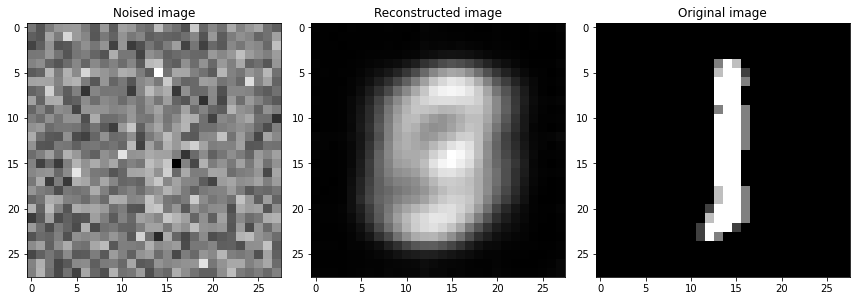

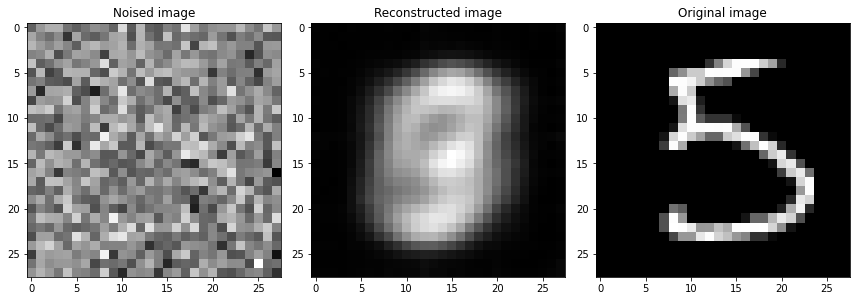

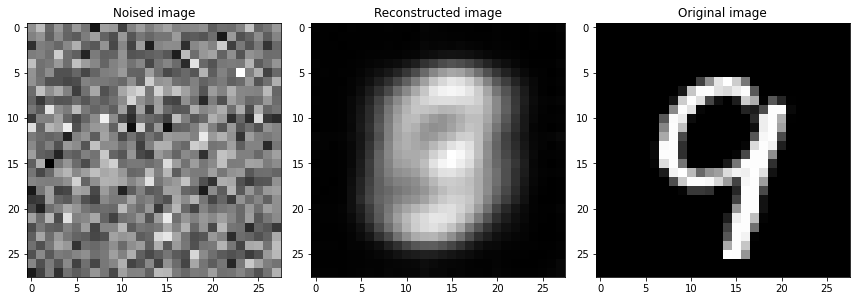

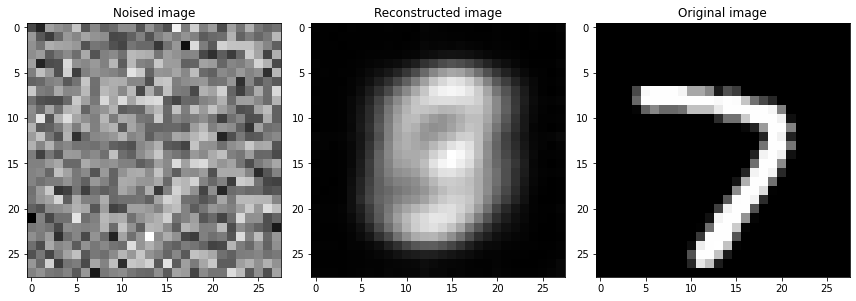

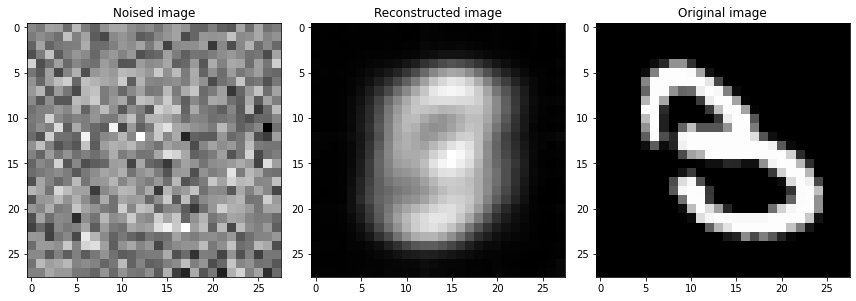

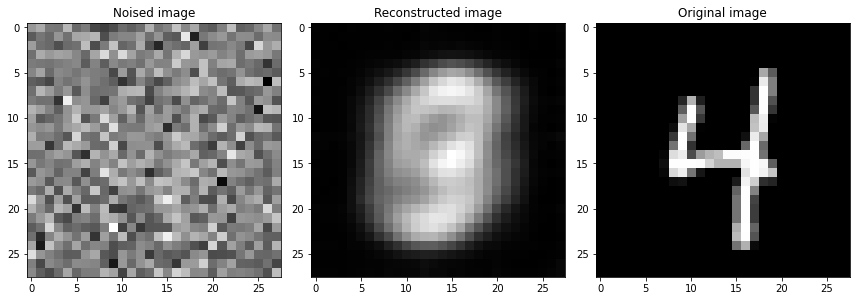

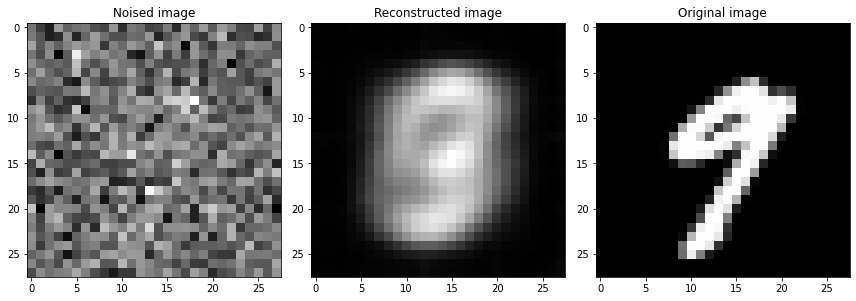

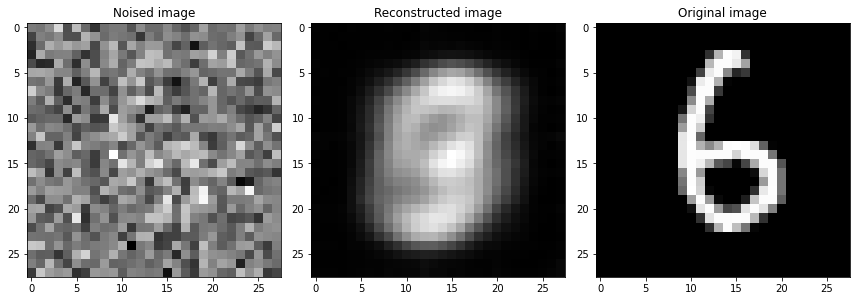

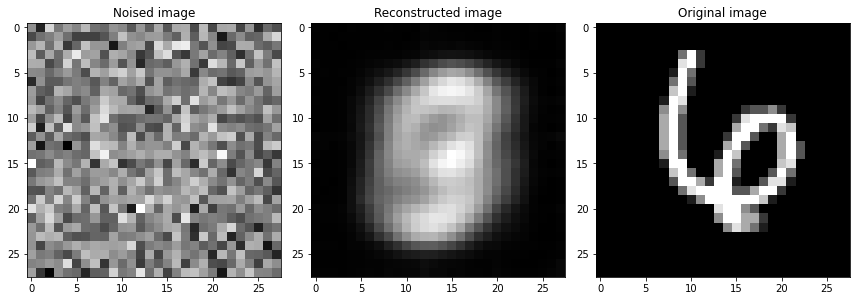

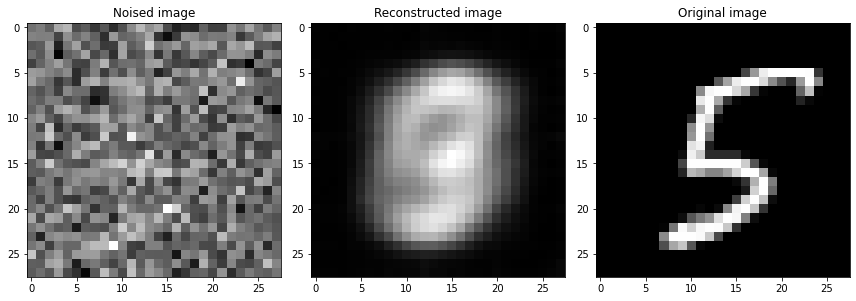

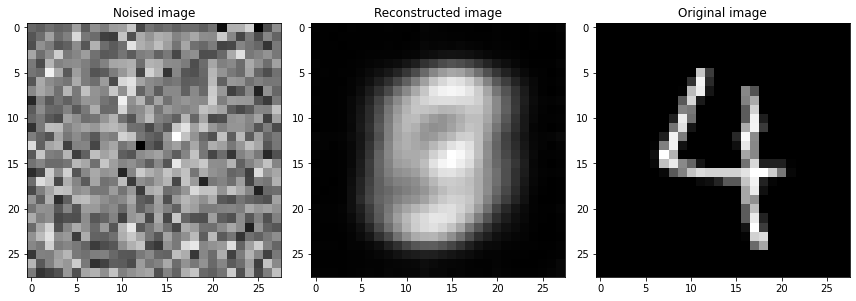

In [ ]:
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(25):
      noised = image_batch[0].to(device)
      encoded = denoise_encoder(noised)
      denoised = denoise_decoder(encoded)
      denoised = denoised[i][0]
      original = image_batch[1][i][0]
      noised = noised[i]

      fig, axs = plt.subplots(1, 3, figsize=(12,6))
      axs[0].imshow(noised.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Noised image')
      axs[1].imshow(denoised.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      axs[2].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[2].set_title('Original image')
      plt.tight_layout()
      plt.pause(0.1)
    break

# Supervised Task

In [ ]:
outputLayer = nn.Linear(encoded_space_dim, 10)
outputLayer = outputLayer.to(device)

In [ ]:
composed_transform = None#transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate

optim = torch.optim.Adam(outputLayer.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
num_epochs = 40
train_accuracy_log = []
val_accuracy_log = []
sig = nn.Sigmoid()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_pred = []
    val_pred = []
    for image_batch in train_dataloader:
      image = image_batch[0].to(device)
      label = image_batch[1].to(device)

      encoded = encoder(image)
      output = outputLayer(encoded)

      loss = loss_fn(output, label)
      outputLayer.zero_grad()
      loss.backward()
      optim.step()

      prediction = torch.argmax(sig(output), dim=1)
      
      accuracy = np.trace(confusion_matrix(prediction.cpu(), label.cpu())) / 100#(prediction == label).int().sum().item() / image.shape[0]
      train_pred.append(accuracy)

    with torch.no_grad():
      for image_batch in val_dataloader:
        image = image_batch[0].to(device)
        label = image_batch[1].to(device)

        encoded = encoder(image)
        output = outputLayer(encoded)

        prediction = torch.argmax(sig(output), dim=1)
        accuracy = (prediction == label).int().sum().item() / image.shape[0]
        val_pred.append(accuracy)

    
    train_pred = np.mean(train_pred)
    print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
    train_accuracy_log.append(train_pred)

    val_pred = np.mean(val_pred)
    print(f"AVERAGE VALIDATION ACCURACY: {val_pred * 100}%")
    val_accuracy_log.append(val_pred)

    
    
    

EPOCH 1/40
AVERAGE TRAIN ACCURACY: 6.122916666666668%
AVERAGE VALIDATION ACCURACY: 1.9166666666666665%
EPOCH 2/40
AVERAGE TRAIN ACCURACY: 11.393749999999999%
AVERAGE VALIDATION ACCURACY: 28.449999999999996%
EPOCH 3/40
AVERAGE TRAIN ACCURACY: 41.65625%
AVERAGE VALIDATION ACCURACY: 48.03333333333333%
EPOCH 4/40
AVERAGE TRAIN ACCURACY: 49.79791666666666%
AVERAGE VALIDATION ACCURACY: 53.19166666666667%
EPOCH 5/40
AVERAGE TRAIN ACCURACY: 54.18958333333334%
AVERAGE VALIDATION ACCURACY: 57.483333333333334%
EPOCH 6/40
AVERAGE TRAIN ACCURACY: 56.96041666666667%
AVERAGE VALIDATION ACCURACY: 59.575%
EPOCH 7/40
AVERAGE TRAIN ACCURACY: 58.20833333333333%
AVERAGE VALIDATION ACCURACY: 59.46666666666667%
EPOCH 8/40
AVERAGE TRAIN ACCURACY: 58.84166666666668%
AVERAGE VALIDATION ACCURACY: 60.94166666666667%
EPOCH 9/40
AVERAGE TRAIN ACCURACY: 59.172916666666666%
AVERAGE VALIDATION ACCURACY: 60.50833333333333%
EPOCH 10/40
AVERAGE TRAIN ACCURACY: 59.31666666666667%
AVERAGE VALIDATION ACCURACY: 60.5333333333

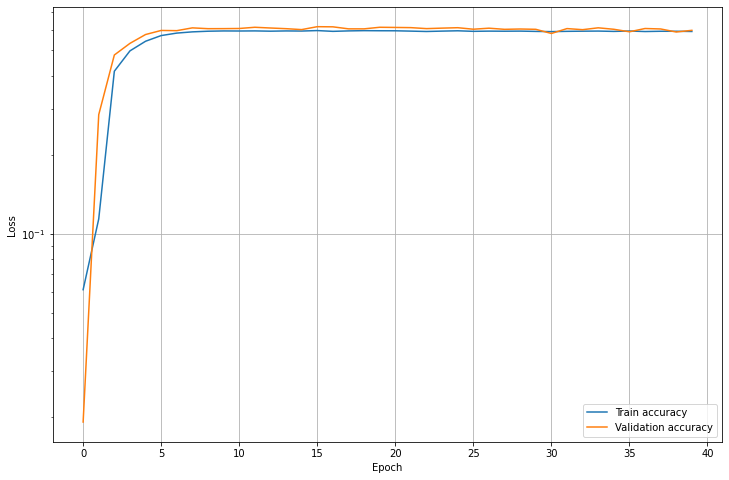

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.semilogy(val_accuracy_log, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
accuracy_tot = []
with torch.no_grad():
  for batch_image in test_dataloader:
    images = batch_image[0].to(device)
    labels = batch_image[1].to(device)

    encoded = encoder(images)
    output = outputLayer(encoded)

    prediction = torch.argmax(sig(output), dim=1)

    conf_mat = confusion_matrix(prediction.cpu(), labels.cpu())
    accuracy = np.trace(conf_mat) / np.sum(conf_mat)
    accuracy_tot.append(accuracy)
  accuracy = np.mean(accuracy_tot)
  print(f"AVERAGE TEST ACCURACY: {accuracy}%")


AVERAGE TEST ACCURACY: 0.5896%


In [ ]:
confusion_matrix(prediction.cpu(), labels.cpu())

array([[ 840,    0,   35,    0,    3,    2,   18,    0,    0,    2],
       [   0, 1033,   23,    3,   18,   27,    4,   81,   17,   12],
       [   9,    6,  806,   16,    1,   21,   14,   13,    8,    0],
       [  10,    2,   23,  778,   36,  423,   15,    8,  400,   43],
       [   1,    1,   10,   13,  642,   38,    3,  528,   21,  707],
       [   0,    1,    8,    4,    1,   25,   18,    0,    6,    1],
       [ 115,    4,   78,   46,   11,   54,  858,    0,   23,    7],
       [   0,    0,    4,    2,  138,    0,    1,  330,    2,  117],
       [   5,   88,   45,  144,   46,  295,   27,   20,  493,   29],
       [   0,    0,    0,    4,   86,    7,    0,   48,    4,   91]])

# GAN

In [ ]:
batch_size = 100
full_dataset = ImageDataset(train_data, transform=None)
test_dataset = ImageDataset(test_data, transform=None)
concat = torch.utils.data.ConcatDataset([full_dataset, test_dataset])
print(len(concat))
train_dataloader = DataLoader(concat, batch_size=batch_size, shuffle=True, num_workers=0)

70000


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
generator = nn.Sequential(
    nn.Linear(100, 3 * 3 * 128),
    nn.Unflatten(dim=1, unflattened_size=(128, 3, 3)),
    #nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=2,  output_padding=0),
    nn.SELU(),
    #nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=2,  padding=1, output_padding=1),
    nn.SELU(),

    nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=2,  padding=1, output_padding=1),
    nn.Sigmoid()
)
generator = generator.to(device)

In [ ]:
discriminator = nn.Sequential (
    nn.Conv2d(1, 64, kernel_size=(3, 3), stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.4),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.4),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
    nn.LeakyReLU(0.2),
    nn.Flatten(start_dim=1),
    nn.Linear(256 * 3 * 3, 1),
    nn.Sigmoid()
)

discriminator = discriminator.to(device)

In [ ]:
rand = torch.randn(batch_size, 100).to(device)
#rand = torch.unsqueeze(rand, 0)
print(rand.shape)
out = generator(rand)
print(out.shape)

output = discriminator(out)
print(output.shape)

torch.Size([100, 100])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1])


In [ ]:
loss_fn = torch.nn.BCELoss()
lr = 0.002 # Learning rate

optimD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

EPOCH 1/50
AVERAGE REAL LOSS: 0.539771556854248
AVERAGE FAKE LOSS: 0.5431527495384216
AVERAGE GENERATOR LOSS: 1.4385254383087158


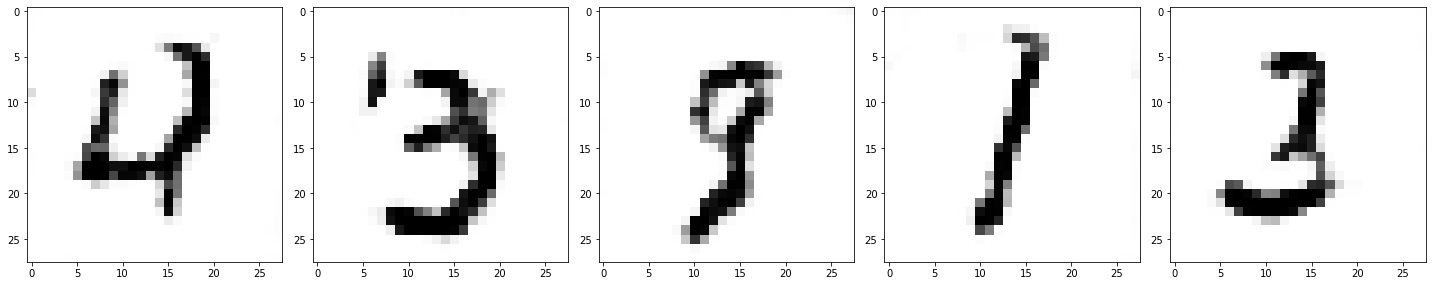

EPOCH 2/50
AVERAGE REAL LOSS: 0.5506660342216492
AVERAGE FAKE LOSS: 0.5482380986213684
AVERAGE GENERATOR LOSS: 1.3559942245483398


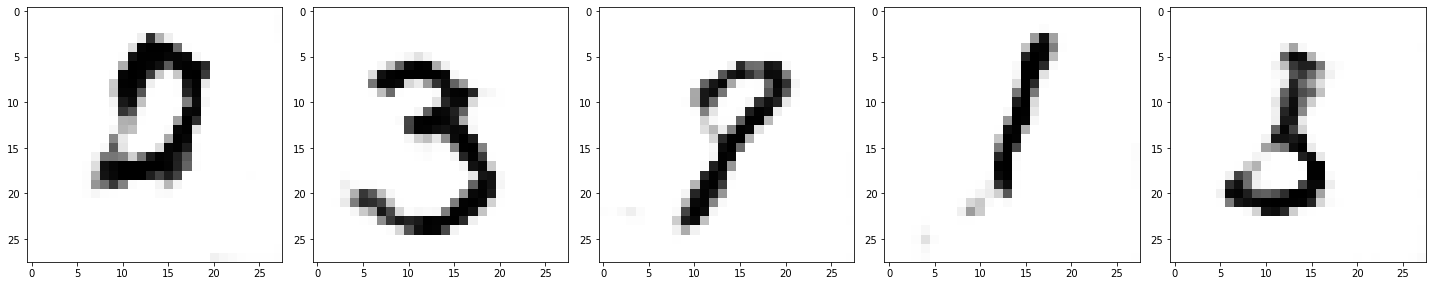

EPOCH 3/50
AVERAGE REAL LOSS: 0.5516933798789978
AVERAGE FAKE LOSS: 0.5428608655929565
AVERAGE GENERATOR LOSS: 1.3684468269348145


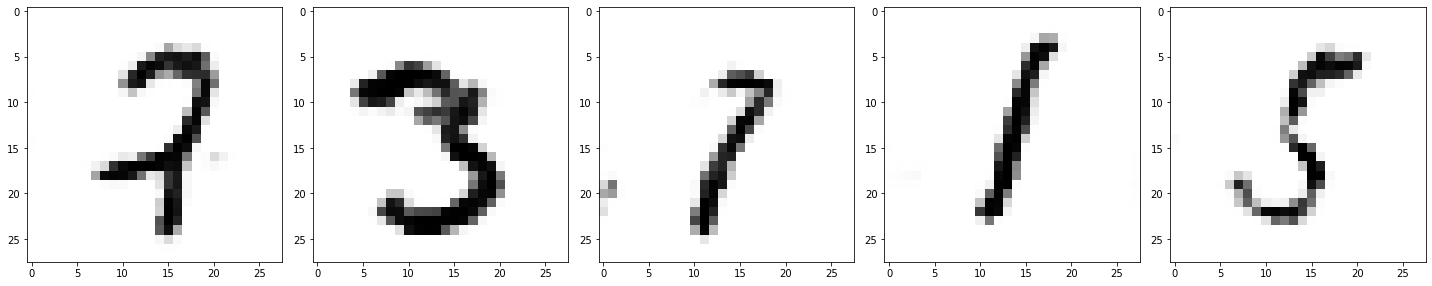

EPOCH 4/50
AVERAGE REAL LOSS: 0.5514501333236694
AVERAGE FAKE LOSS: 0.5385441184043884
AVERAGE GENERATOR LOSS: 1.3796981573104858


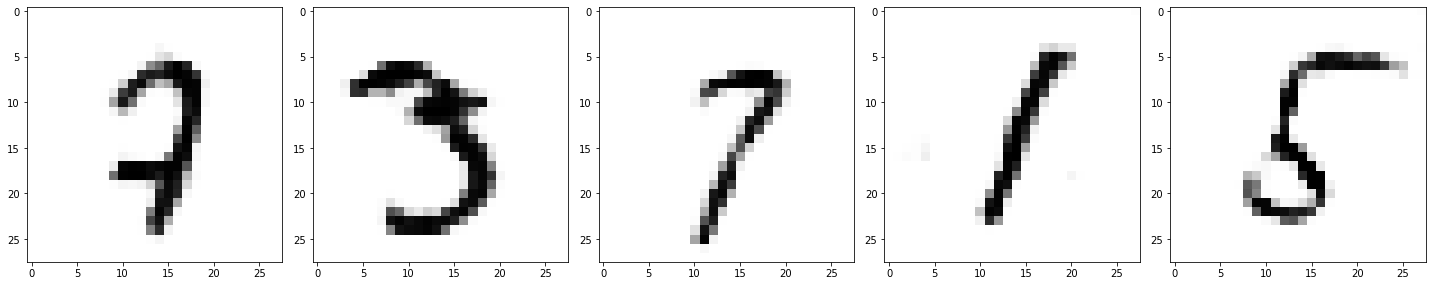

EPOCH 5/50
AVERAGE REAL LOSS: 0.5504655838012695
AVERAGE FAKE LOSS: 0.5394977927207947
AVERAGE GENERATOR LOSS: 1.3815728425979614


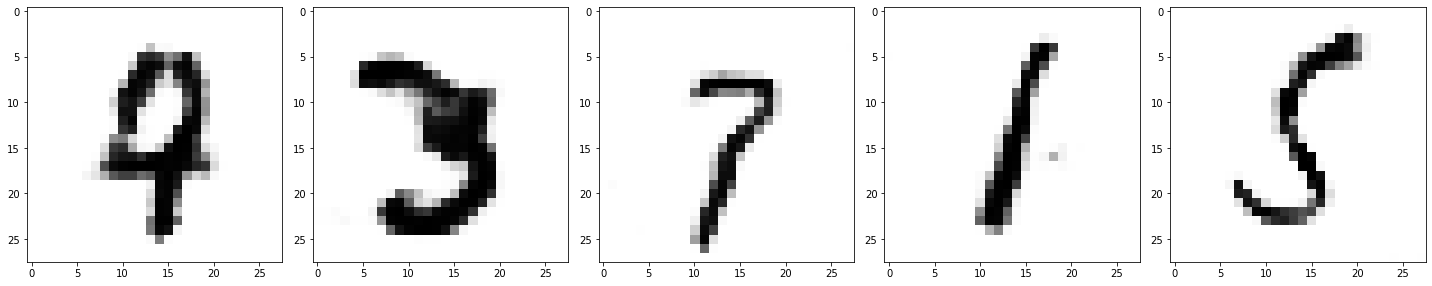

EPOCH 6/50
AVERAGE REAL LOSS: 0.5502591133117676
AVERAGE FAKE LOSS: 0.5372117161750793
AVERAGE GENERATOR LOSS: 1.386367917060852


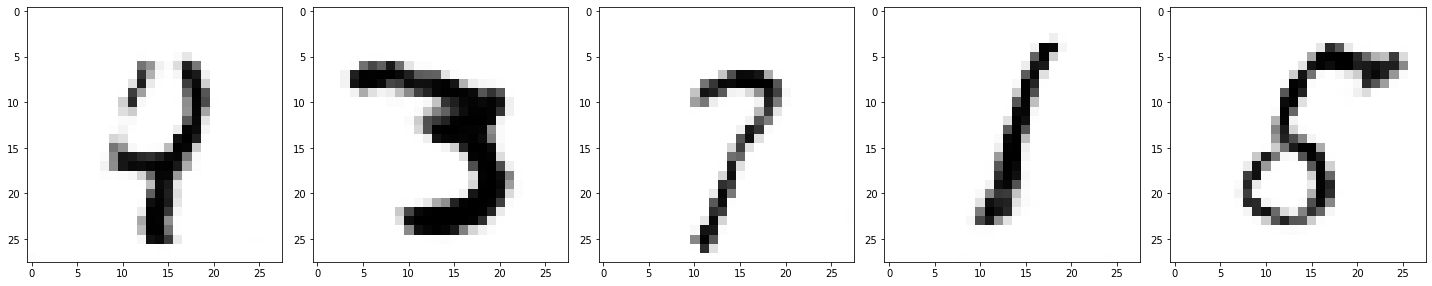

EPOCH 7/50
AVERAGE REAL LOSS: 0.5458916425704956
AVERAGE FAKE LOSS: 0.5330764055252075
AVERAGE GENERATOR LOSS: 1.4014546871185303


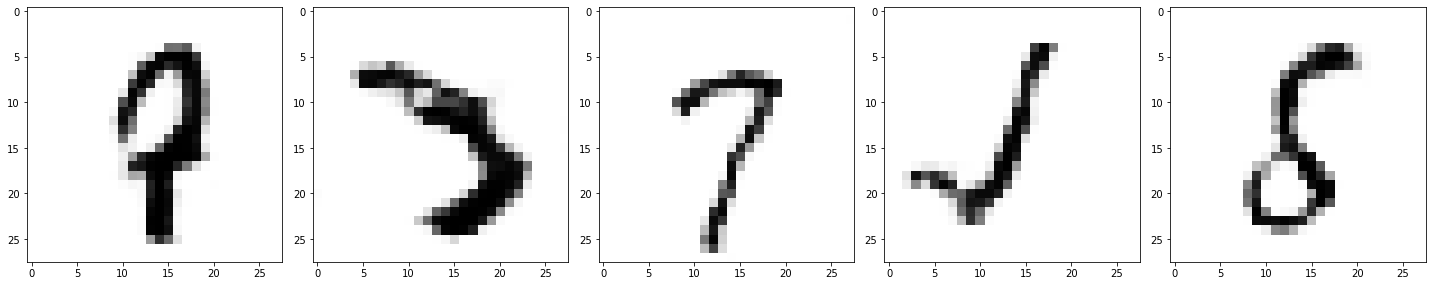

EPOCH 8/50
AVERAGE REAL LOSS: 0.5469671487808228
AVERAGE FAKE LOSS: 0.5337381362915039
AVERAGE GENERATOR LOSS: 1.412070870399475


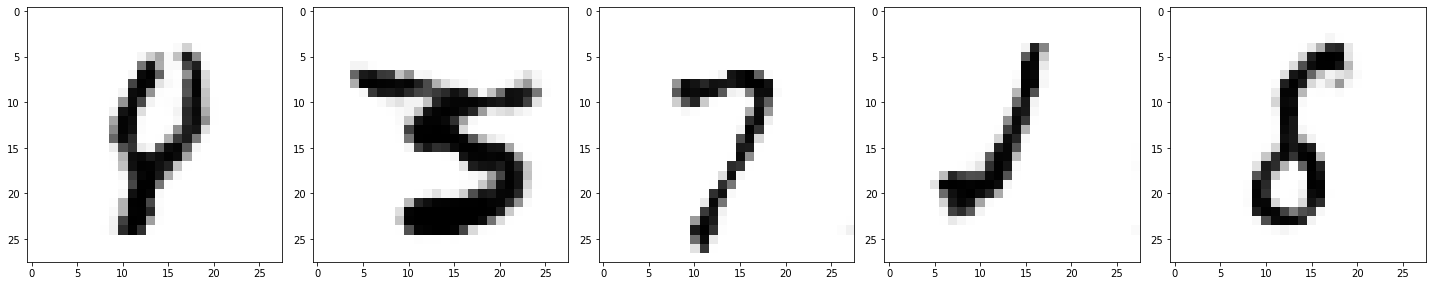

EPOCH 9/50
AVERAGE REAL LOSS: 0.5440792441368103
AVERAGE FAKE LOSS: 0.5302626490592957
AVERAGE GENERATOR LOSS: 1.4297640323638916


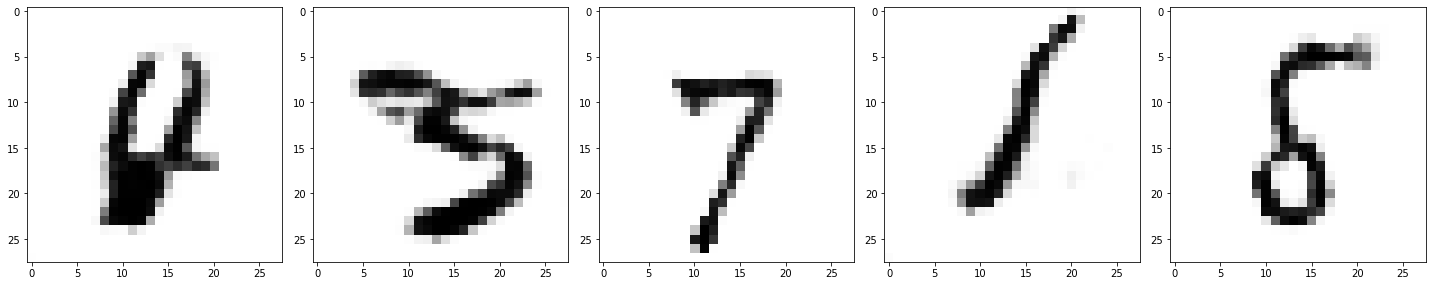

EPOCH 10/50
AVERAGE REAL LOSS: 0.5407764315605164
AVERAGE FAKE LOSS: 0.5241143703460693
AVERAGE GENERATOR LOSS: 1.4349243640899658


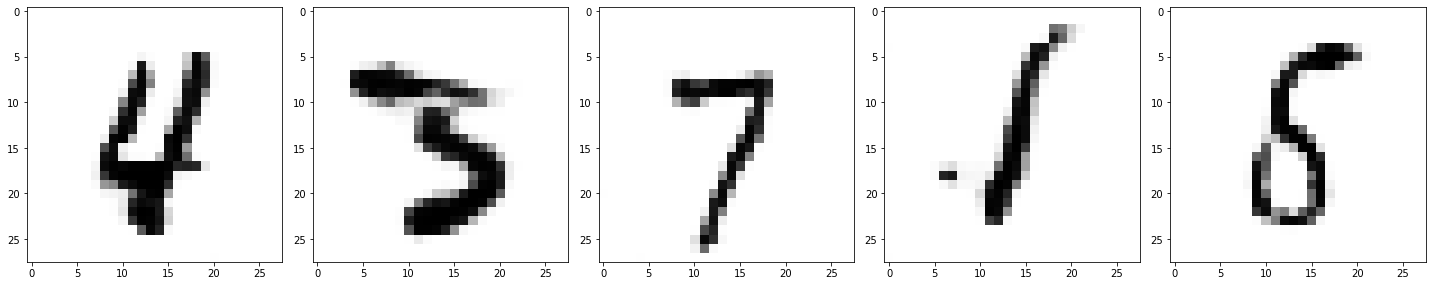

EPOCH 11/50
AVERAGE REAL LOSS: 0.5376347303390503
AVERAGE FAKE LOSS: 0.5213304758071899
AVERAGE GENERATOR LOSS: 1.4490467309951782


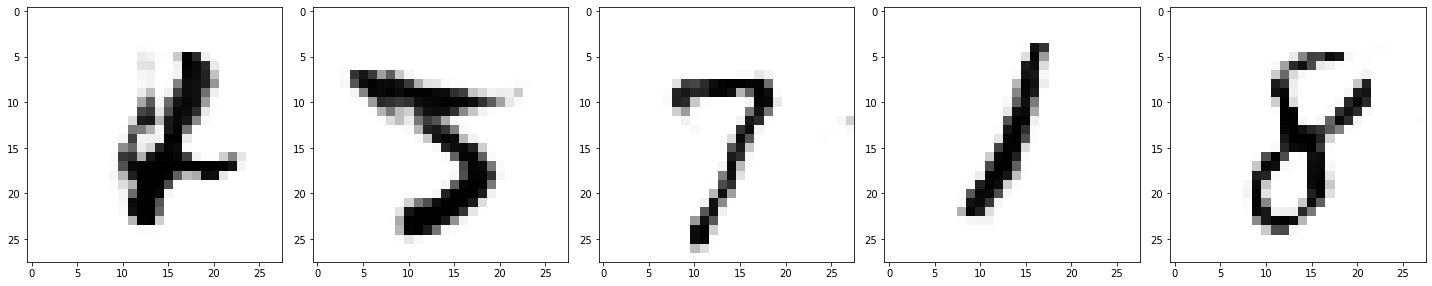

EPOCH 12/50
AVERAGE REAL LOSS: 0.5369590520858765
AVERAGE FAKE LOSS: 0.5186222791671753
AVERAGE GENERATOR LOSS: 1.4545509815216064


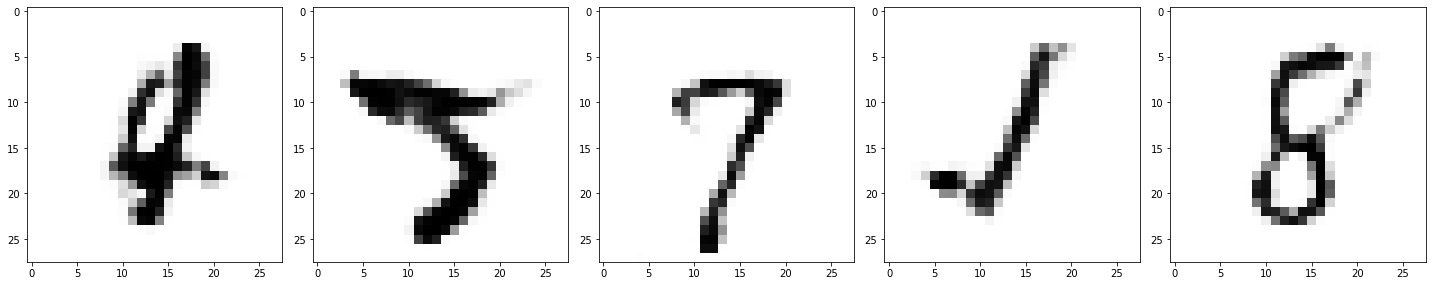

EPOCH 13/50
AVERAGE REAL LOSS: 0.5388028025627136
AVERAGE FAKE LOSS: 0.5189228653907776
AVERAGE GENERATOR LOSS: 1.4649533033370972


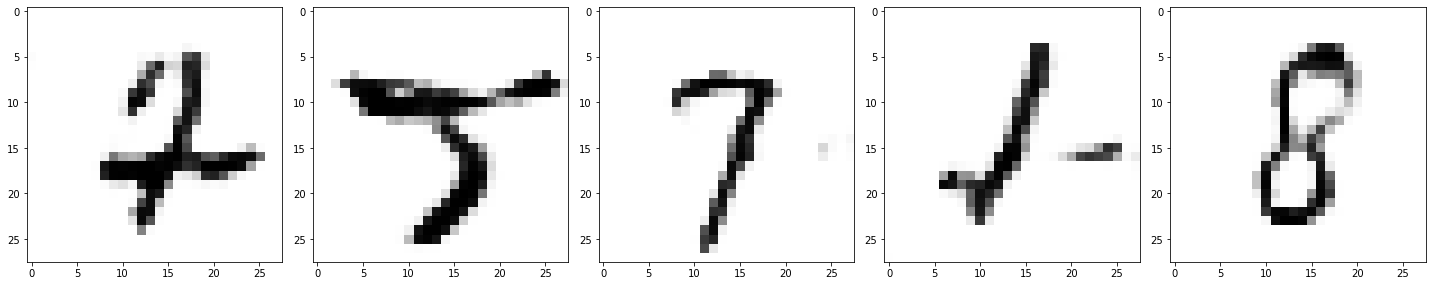

EPOCH 14/50
AVERAGE REAL LOSS: 0.5295743942260742
AVERAGE FAKE LOSS: 0.5088979601860046
AVERAGE GENERATOR LOSS: 1.4693362712860107


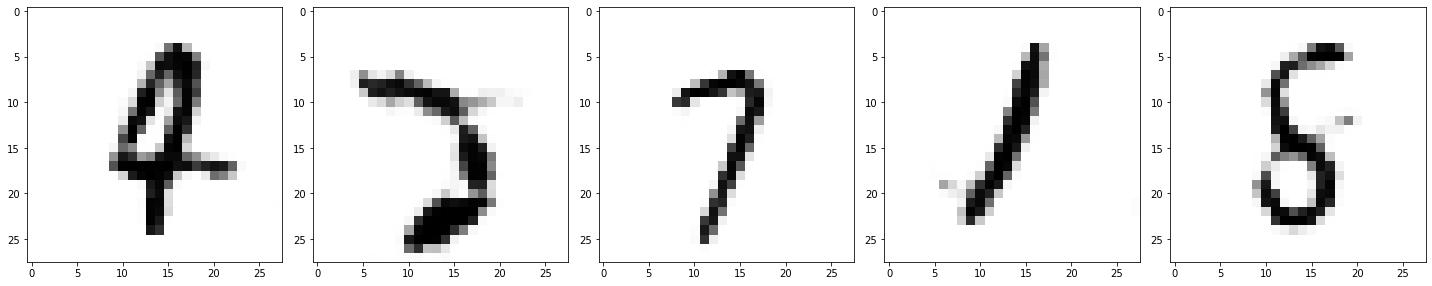

EPOCH 15/50
AVERAGE REAL LOSS: 0.5494443774223328
AVERAGE FAKE LOSS: 0.5524919033050537
AVERAGE GENERATOR LOSS: 1.4163092374801636


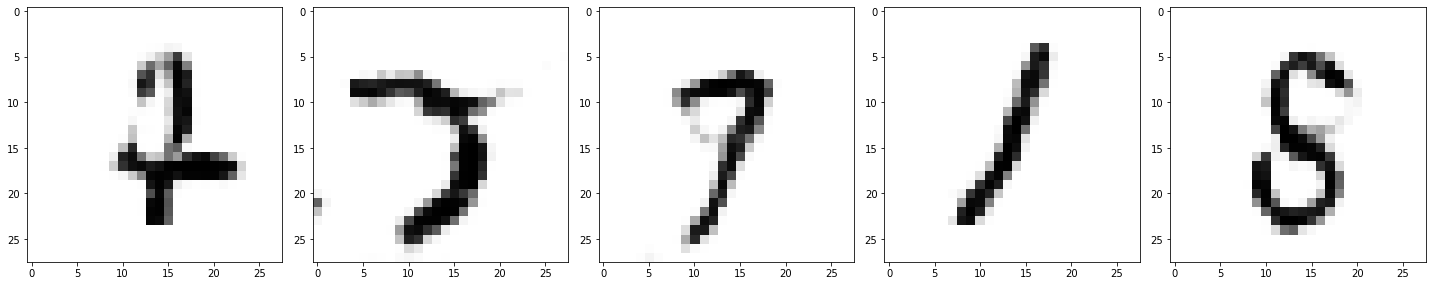

EPOCH 16/50
AVERAGE REAL LOSS: 0.5238175988197327
AVERAGE FAKE LOSS: 0.5035392642021179
AVERAGE GENERATOR LOSS: 1.4872424602508545


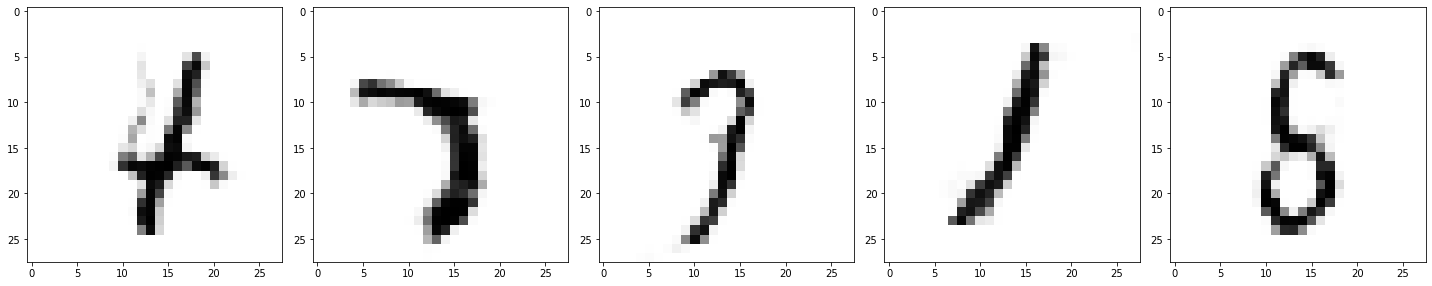

EPOCH 17/50
AVERAGE REAL LOSS: 0.5237687230110168
AVERAGE FAKE LOSS: 0.5040735006332397
AVERAGE GENERATOR LOSS: 1.4984246492385864


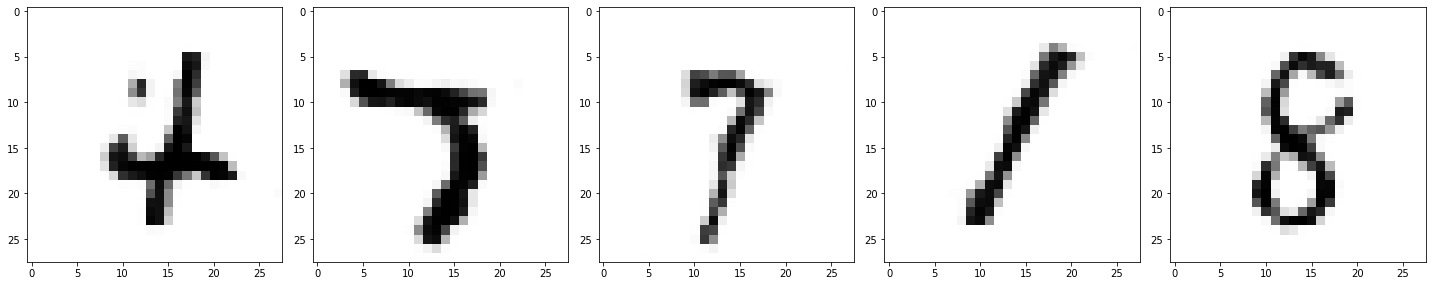

EPOCH 18/50
AVERAGE REAL LOSS: 0.523760199546814
AVERAGE FAKE LOSS: 0.5029526948928833
AVERAGE GENERATOR LOSS: 1.5180095434188843


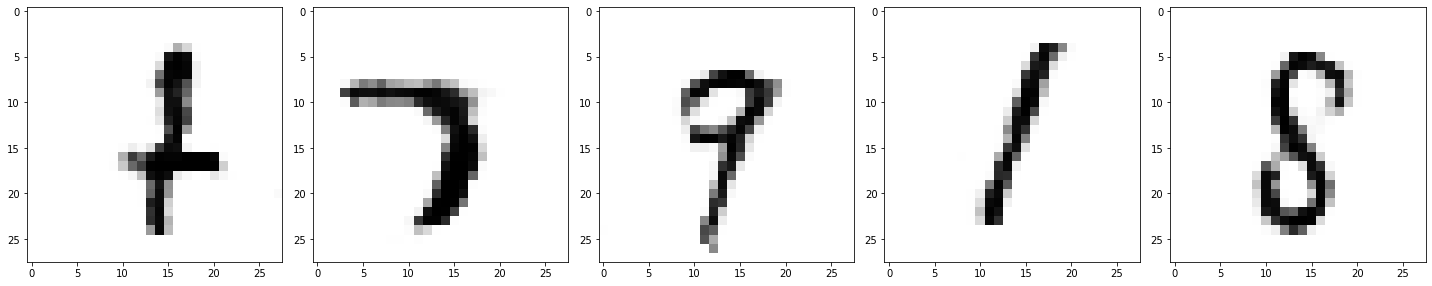

EPOCH 19/50
AVERAGE REAL LOSS: 0.5357080698013306
AVERAGE FAKE LOSS: 0.5214276313781738
AVERAGE GENERATOR LOSS: 1.4860553741455078


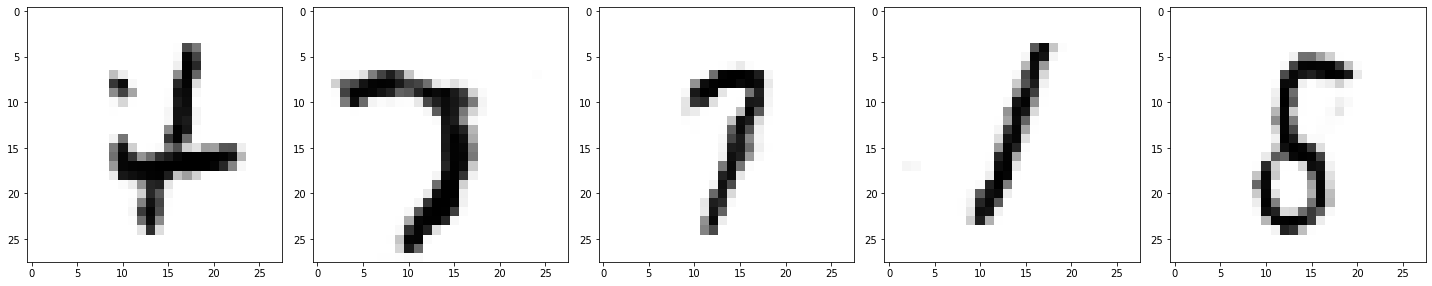

EPOCH 20/50
AVERAGE REAL LOSS: 0.5196331143379211
AVERAGE FAKE LOSS: 0.49889904260635376
AVERAGE GENERATOR LOSS: 1.527323842048645


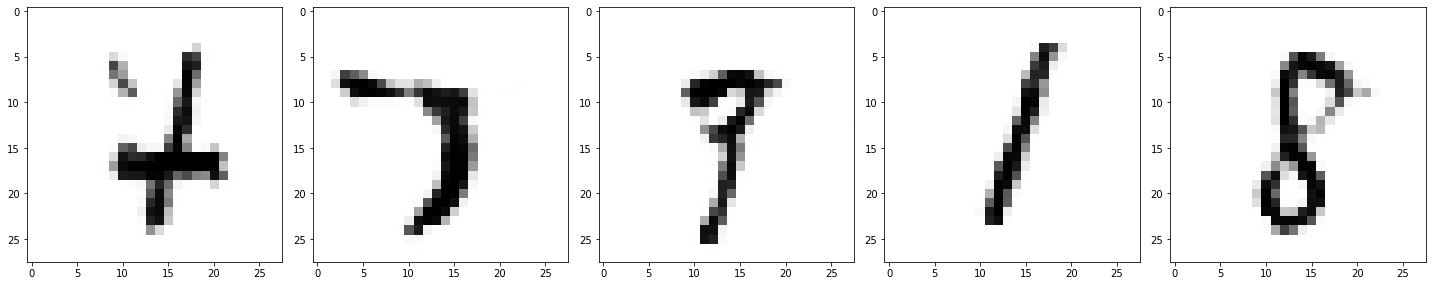

EPOCH 21/50
AVERAGE REAL LOSS: 0.5168042778968811
AVERAGE FAKE LOSS: 0.4946015775203705
AVERAGE GENERATOR LOSS: 1.5481431484222412


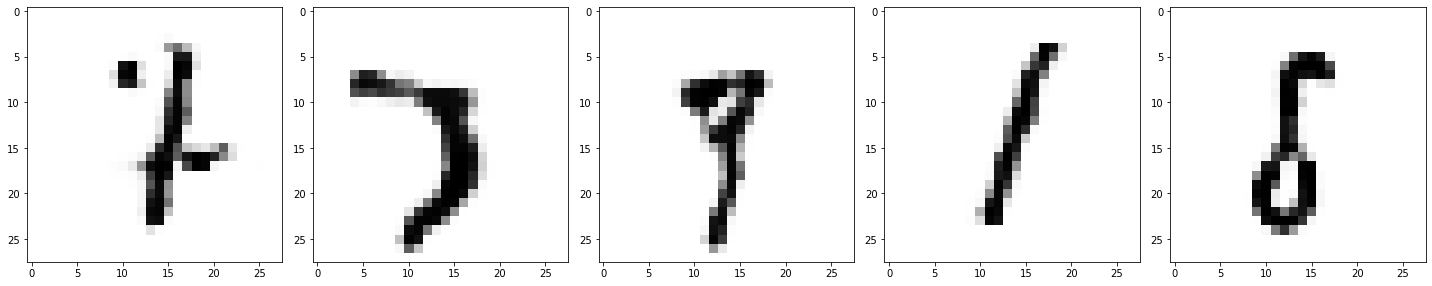

EPOCH 22/50
AVERAGE REAL LOSS: 0.5175065994262695
AVERAGE FAKE LOSS: 0.49436500668525696
AVERAGE GENERATOR LOSS: 1.5582987070083618


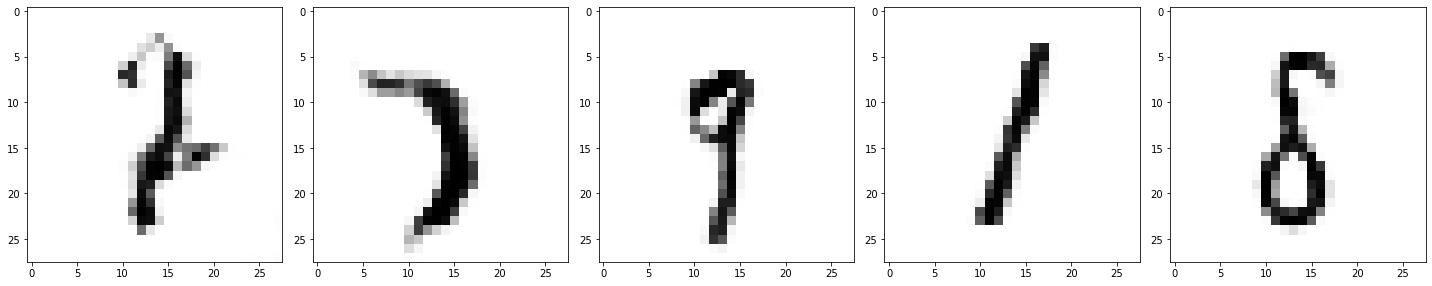

EPOCH 23/50
AVERAGE REAL LOSS: 0.5147624611854553
AVERAGE FAKE LOSS: 0.4930315613746643
AVERAGE GENERATOR LOSS: 1.5643038749694824


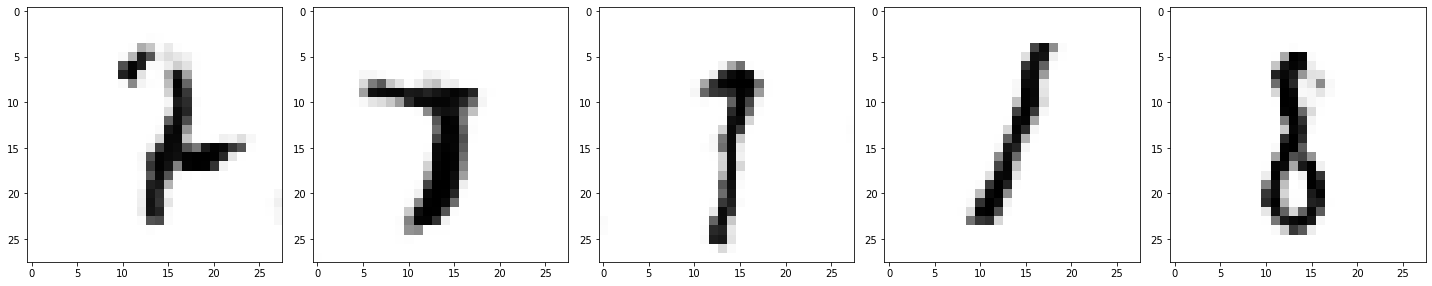

EPOCH 24/50
AVERAGE REAL LOSS: 0.5218702554702759
AVERAGE FAKE LOSS: 0.5050838589668274
AVERAGE GENERATOR LOSS: 1.5620113611221313


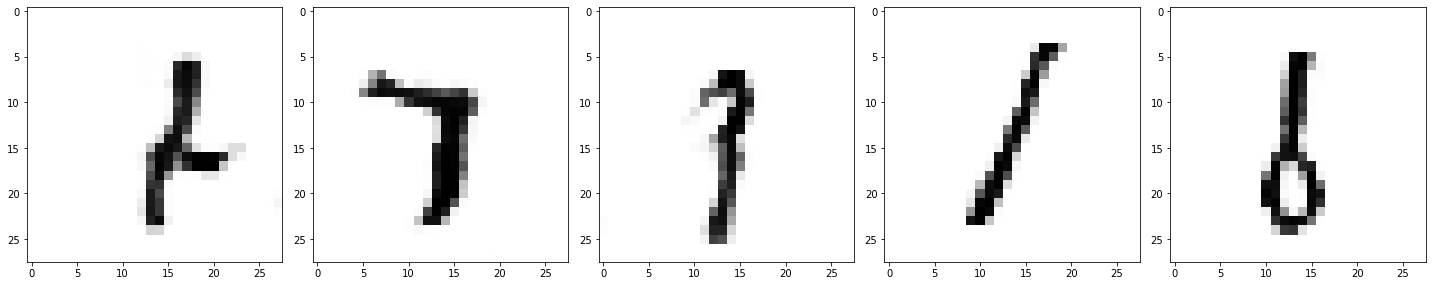

EPOCH 25/50
AVERAGE REAL LOSS: 0.5051918029785156
AVERAGE FAKE LOSS: 0.4817688763141632
AVERAGE GENERATOR LOSS: 1.5962457656860352


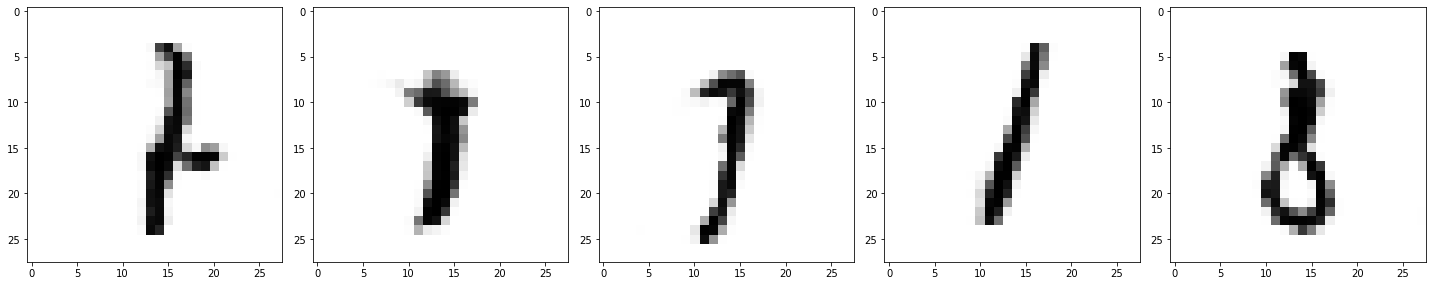

EPOCH 26/50
AVERAGE REAL LOSS: 0.5057393908500671
AVERAGE FAKE LOSS: 0.48155248165130615
AVERAGE GENERATOR LOSS: 1.6179752349853516


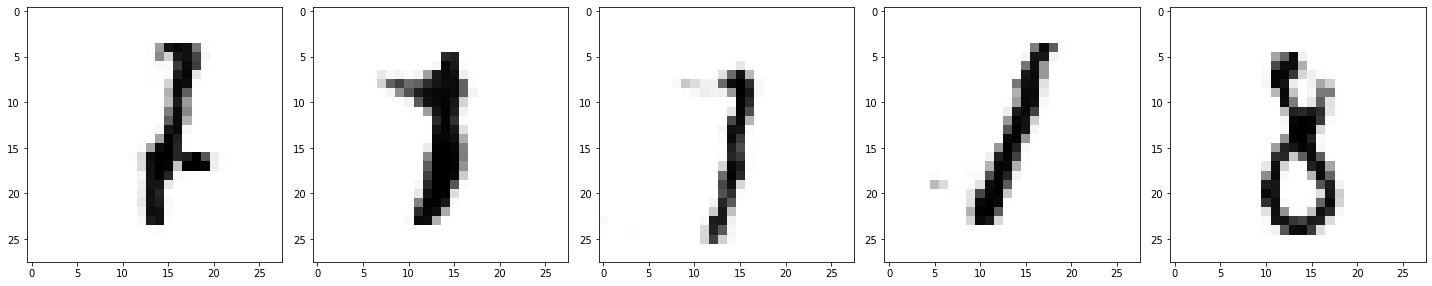

EPOCH 27/50
AVERAGE REAL LOSS: 0.5185463428497314
AVERAGE FAKE LOSS: 0.5024272799491882
AVERAGE GENERATOR LOSS: 1.5959073305130005


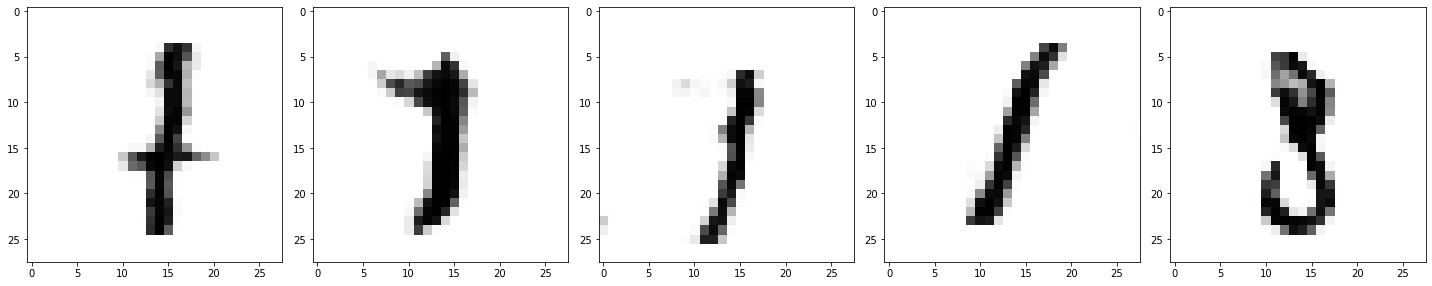

EPOCH 28/50
AVERAGE REAL LOSS: 0.5030993819236755
AVERAGE FAKE LOSS: 0.47823062539100647
AVERAGE GENERATOR LOSS: 1.6074591875076294


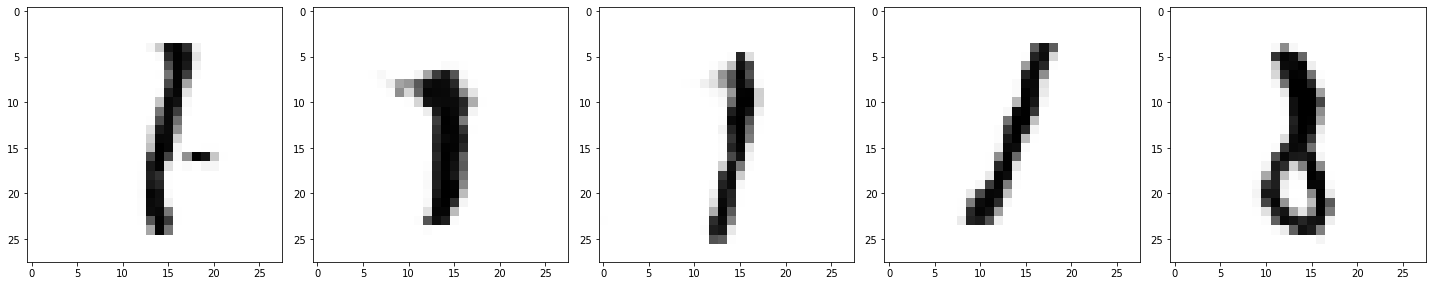

EPOCH 29/50


KeyboardInterrupt: ignored

In [ ]:
epochs = 50
train_loss_tot = []
fake_label = 0
real_label = 1
rand_const = torch.randn(batch_size, 100).to(device)
for epoch in range(epochs):
  print(f"EPOCH {epoch+1}/{epochs}")
  real_loss_batch = []
  fake_loss_batch = []
  generator_loss_batch = []
  for image_batch in train_dataloader:
    #Step1 

    #Training with real images
    generator.zero_grad()
    real_images = image_batch[0].to(device)
    
    output_real = discriminator(real_images).view(-1)
    labels = torch.full((output_real.shape[0],), real_label, dtype=torch.float, device=device)
    loss_real = loss_fn(output_real, labels)
    discriminator.zero_grad()
    loss_real.backward()
    real_loss_batch.append(loss_real.detach().cpu().numpy())

    #Training with fake images
    rand = torch.randn(batch_size, 100).to(device)
    fake_images = generator(rand)
    labels.fill_(fake_label)
    output_fake = discriminator(fake_images).view(-1)
    loss_fake = loss_fn(output_fake, labels)
    loss_fake.backward(retain_graph=True)
    fake_loss_batch.append(loss_fake.detach().cpu().numpy())

    optimD.step()


    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    generator.zero_grad()
    labels.fill_(real_label) 
    output = discriminator(fake_images).view(-1)
    loss_generator = loss_fn(output, labels)
    loss_generator.backward()
    generator_loss_batch.append(loss_generator.detach().cpu().numpy())

    optimG.step()


  real_loss_batch = np.mean(real_loss_batch)
  fake_loss_batch = np.mean(fake_loss_batch)
  generator_loss_batch = np.mean(generator_loss_batch)
  print(f"AVERAGE REAL LOSS: {real_loss_batch}")
  print(f"AVERAGE FAKE LOSS: {fake_loss_batch}")
  print(f"AVERAGE GENERATOR LOSS: {generator_loss_batch}")
  fig, axs = plt.subplots(1, 5, figsize=(20,20))
  out = generator(rand_const).detach().cpu().numpy()
  for j in range(5):
    img = out[j][0]
    axs[j].imshow(img, cmap='Greys')
    axs[j].set_title('')
  plt.tight_layout()
  #out = generator(rand)
  #fig = plt.figure(figsize=(8,8))
  #plt.imshow(out.detach().cpu().numpy()[0][0], cmap='Greys')
  plt.pause(0.1)

    

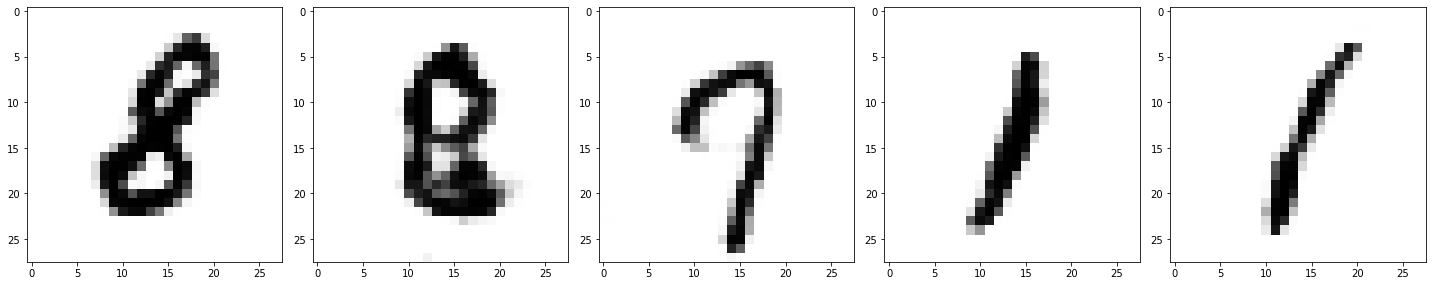

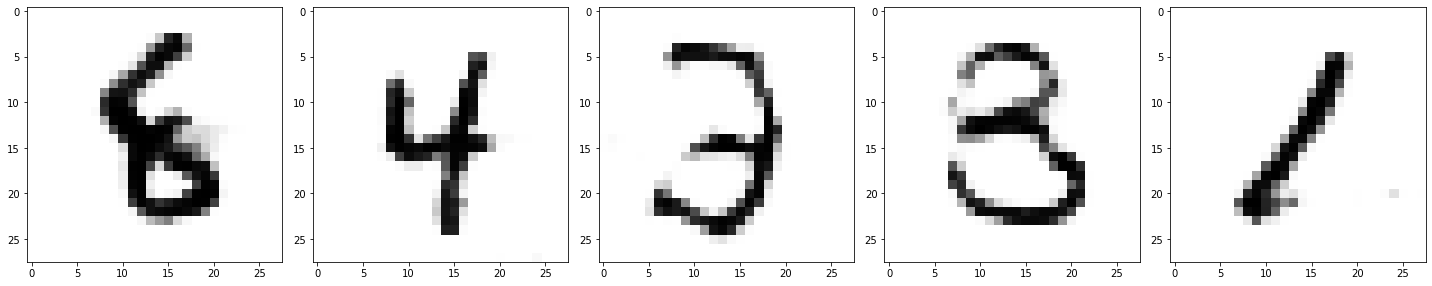

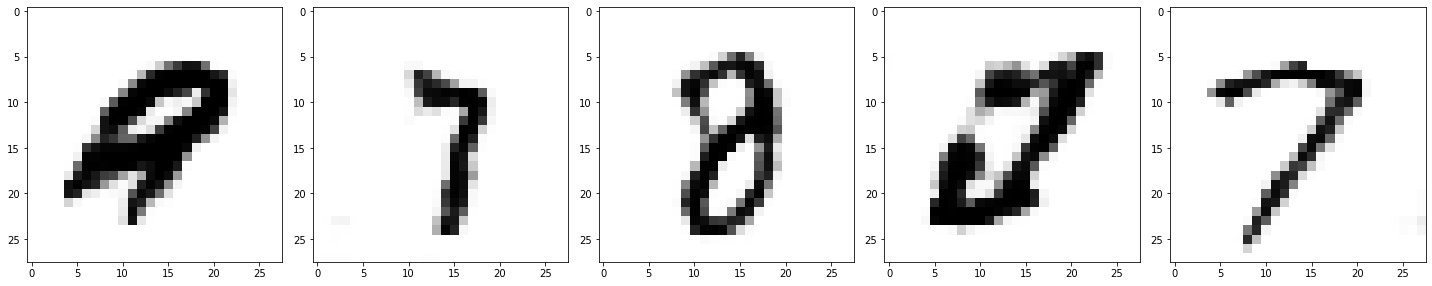

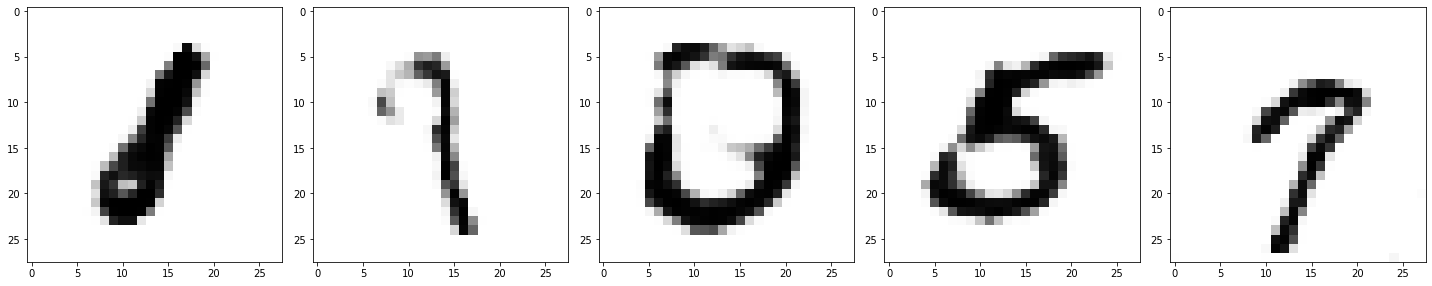

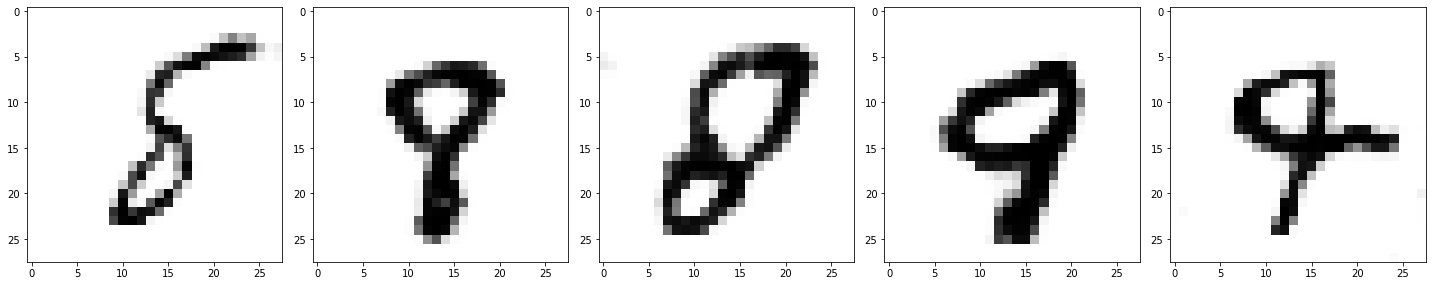

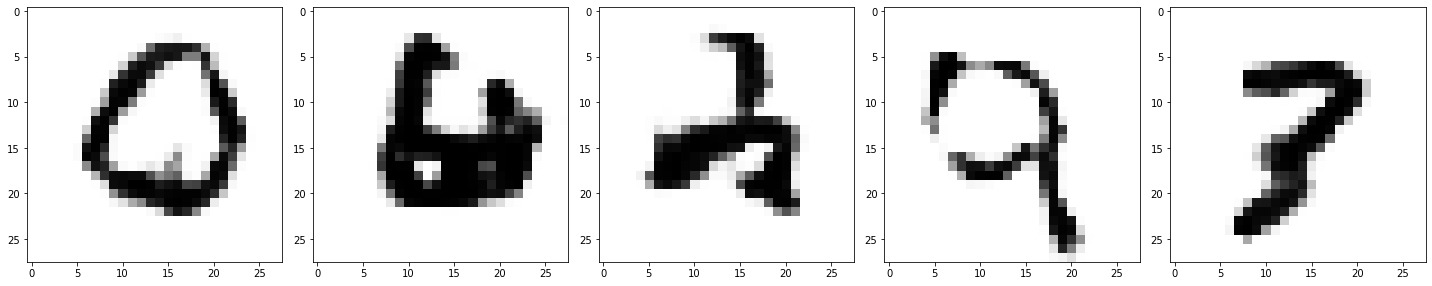

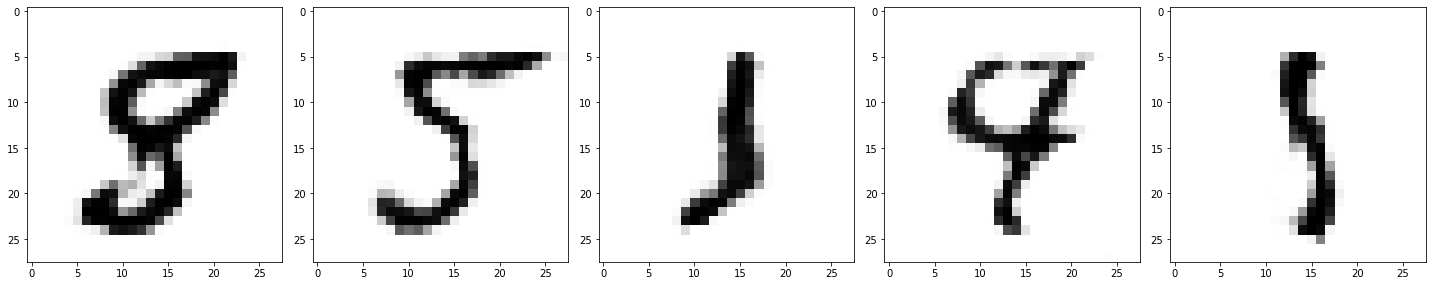

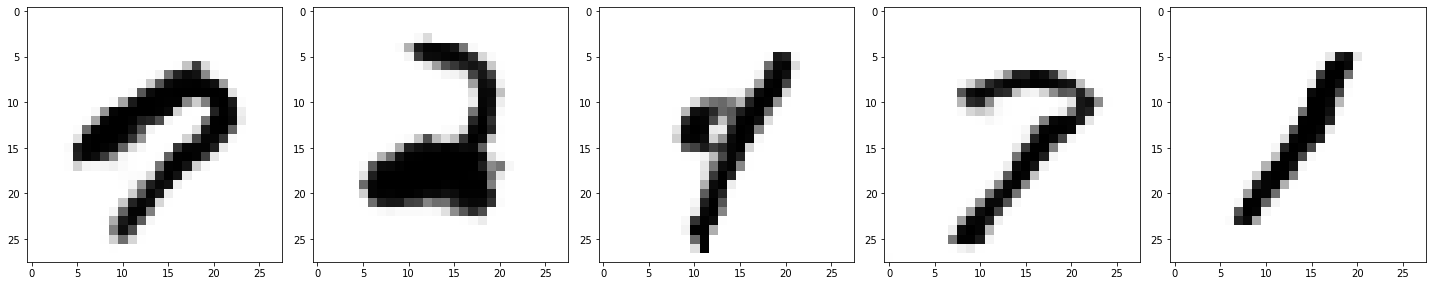

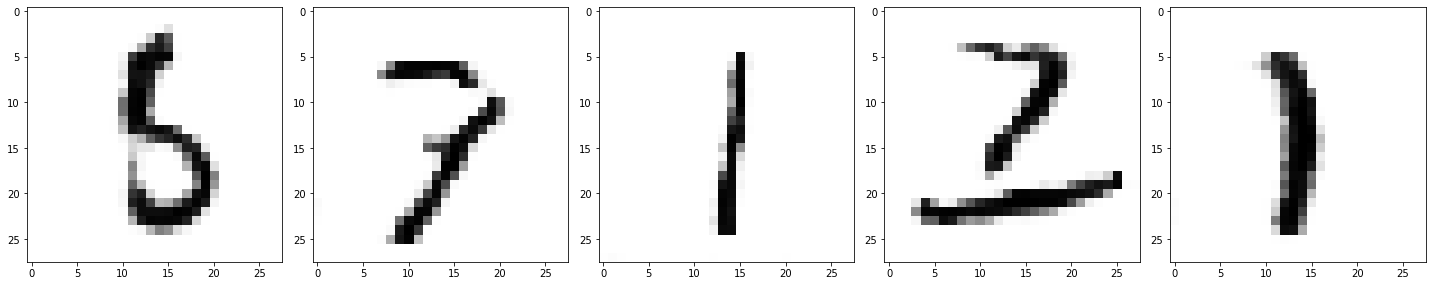

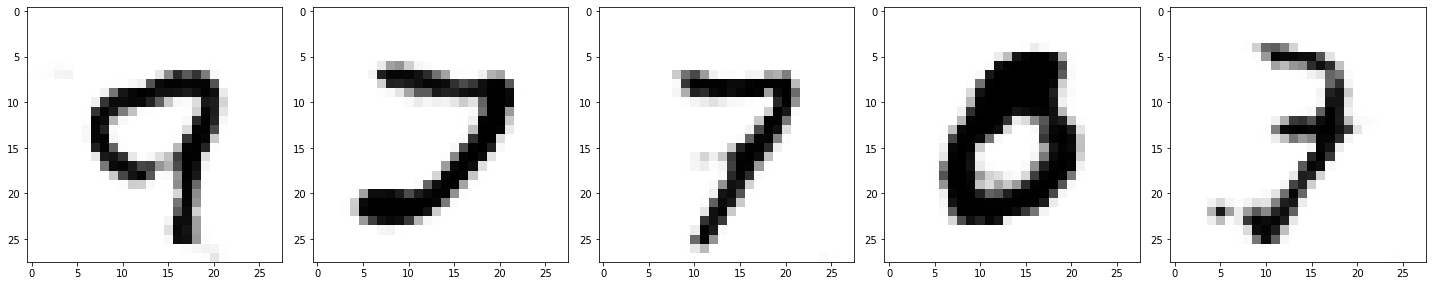

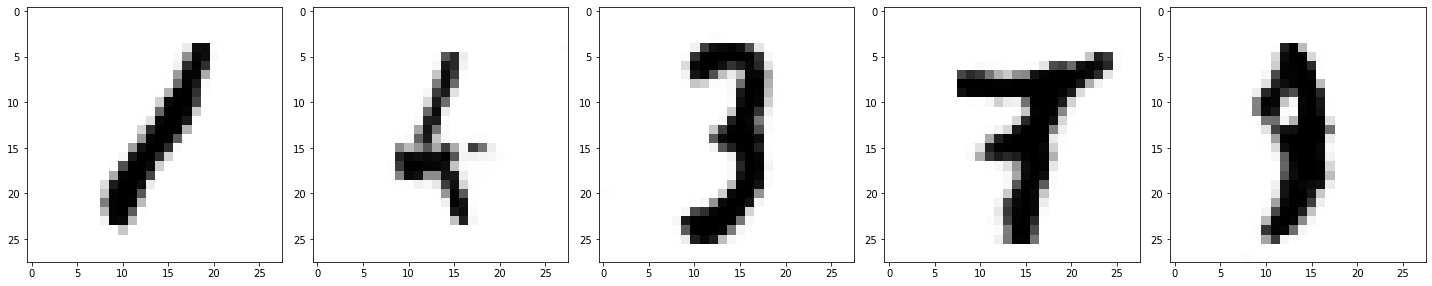

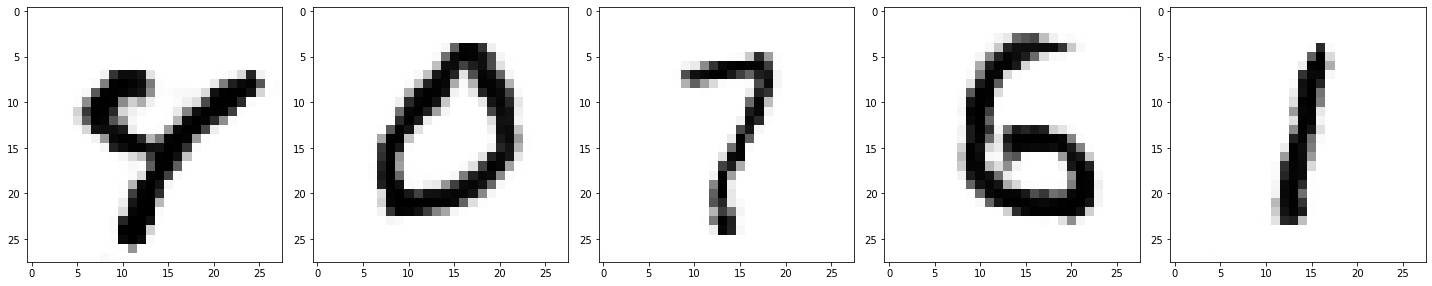

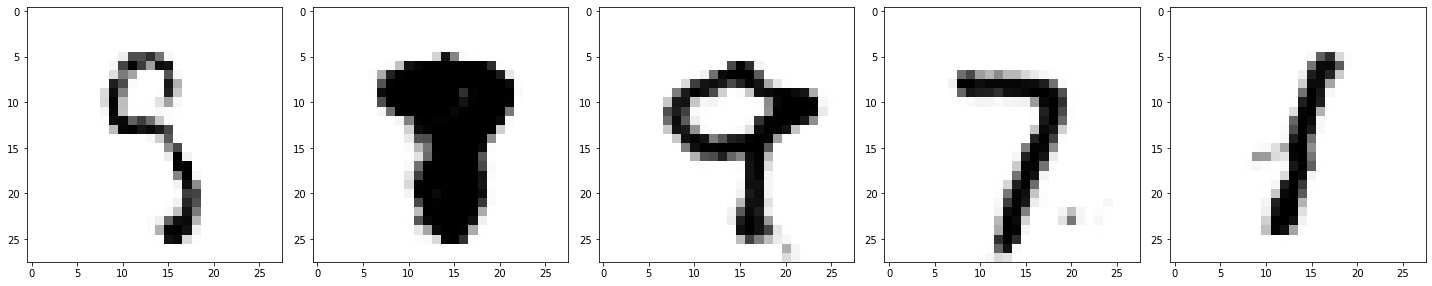

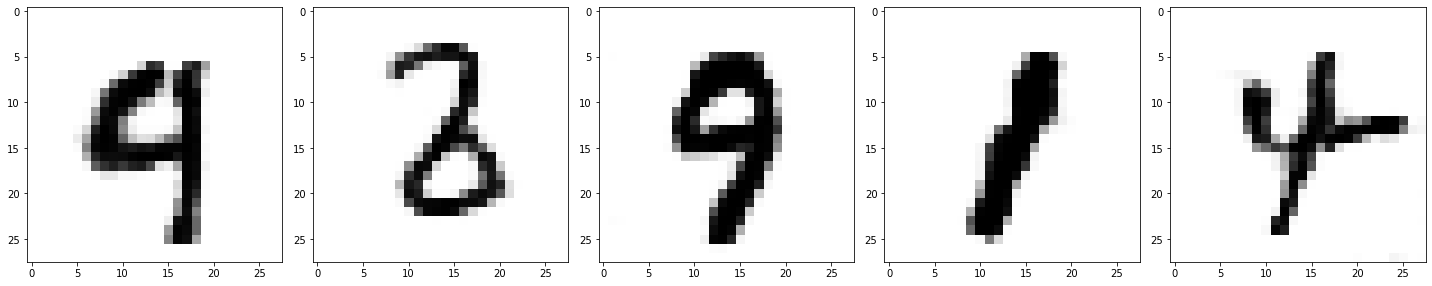

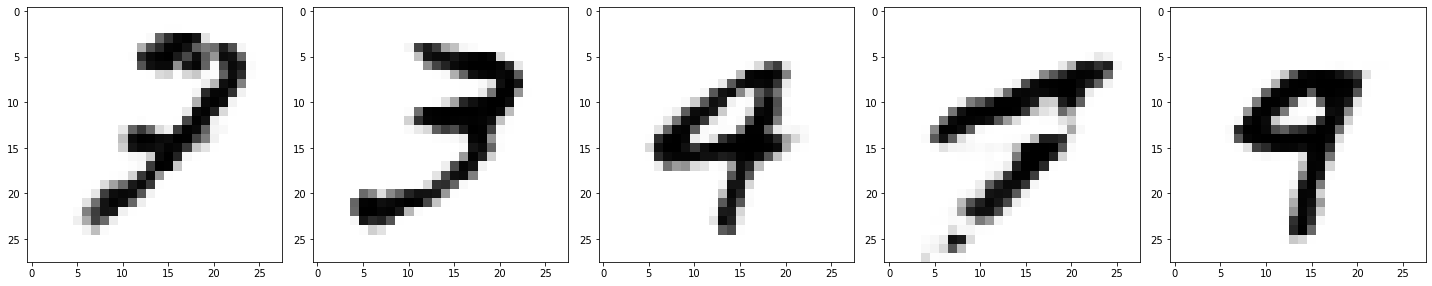

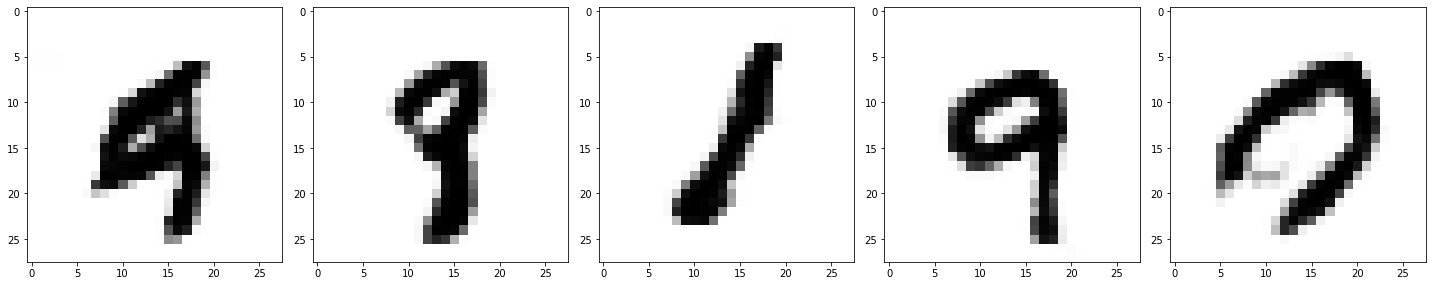

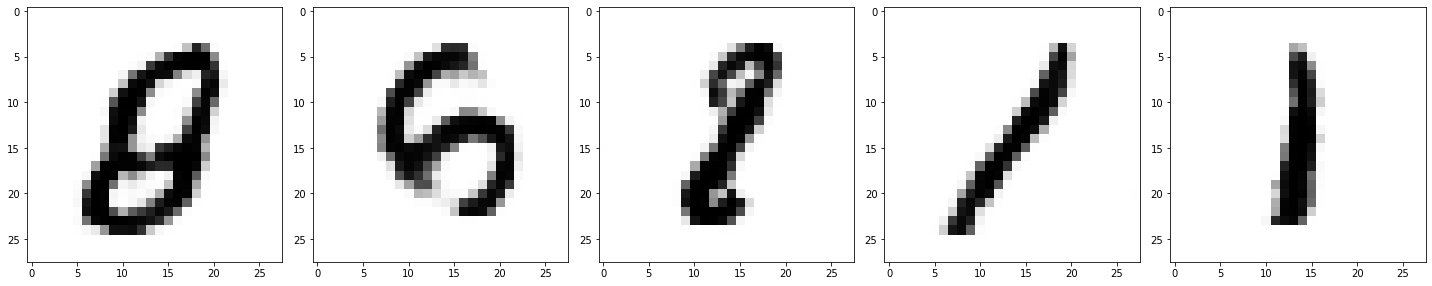

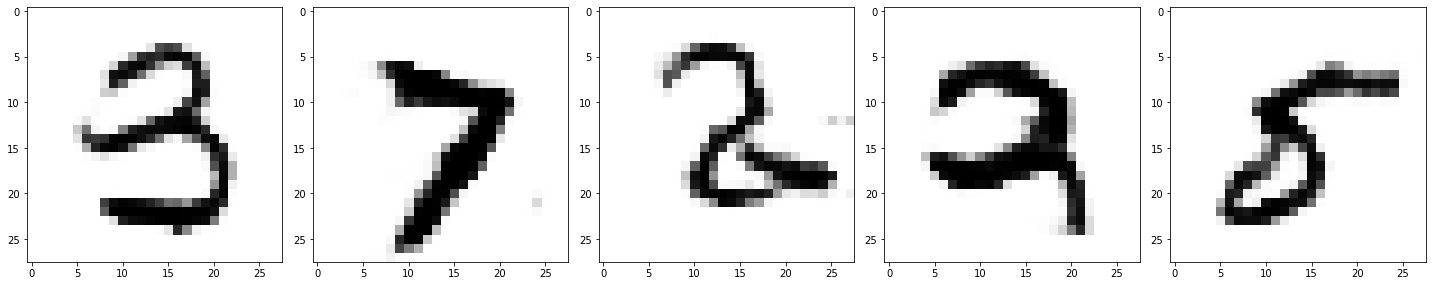

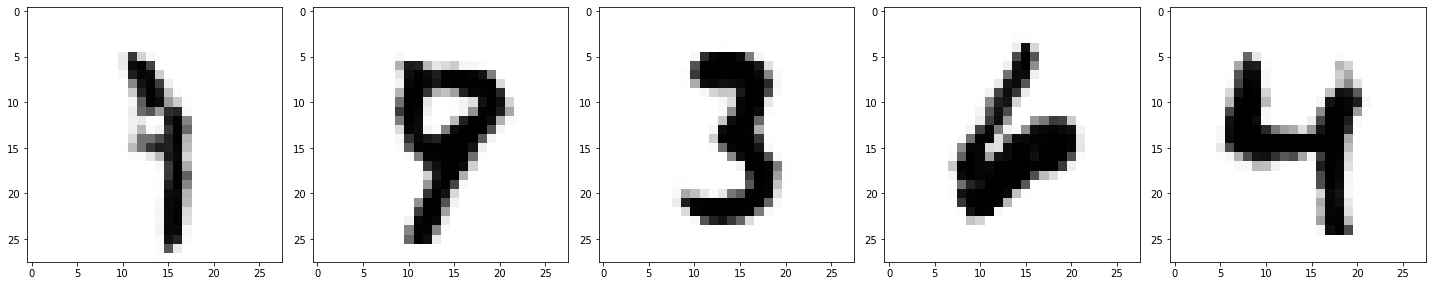

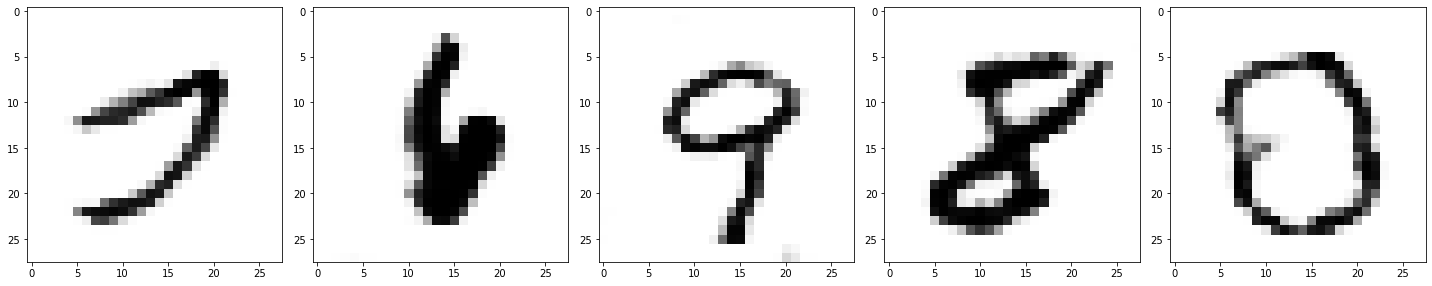

In [ ]:
rand = torch.randn(batch_size, 100).to(device)
out = generator(rand).detach().cpu().numpy()
num_rows = int(out.shape[0] / 5)
index = 0
for i in range(num_rows):
  fig, axs = plt.subplots(1, 5, figsize=(20,20))
  for j in range(5):
    img = out[index][0]
    index += 1
    axs[j].imshow(img, cmap='Greys')
    axs[j].set_title('')
    plt.tight_layout()
  plt.pause(0.1)
